<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Módulo 7</font></h2>



<h1><font color="#00586D" size=5>Machine Learning con series temporales</font></h1>
<br><br>

<div align="right">
<font color="#00586D" size=3>Luis de la Ossa</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

# Optimiza los gráficos para pantalla retina
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#Colores
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]

# La libreta ocupa así el 95% de la pantalla
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import pandas as pd
import numpy as np

---

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>


* [1. Pronóstico con Machine Learning](#section1)
* [2. Comparación de series: Dynamic Time Warping](#section2)
* [3. Aprendizaje supervisado con series](#section3)
* [4.  Detección de anomalías en series temporales](#section4)

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section1"></a> 
## <font color="#00586D"> 1. Pronóstico con Machine Learning</font>
<br>

### <font color="#00586D"> Ejemplo: AR(2)</font>

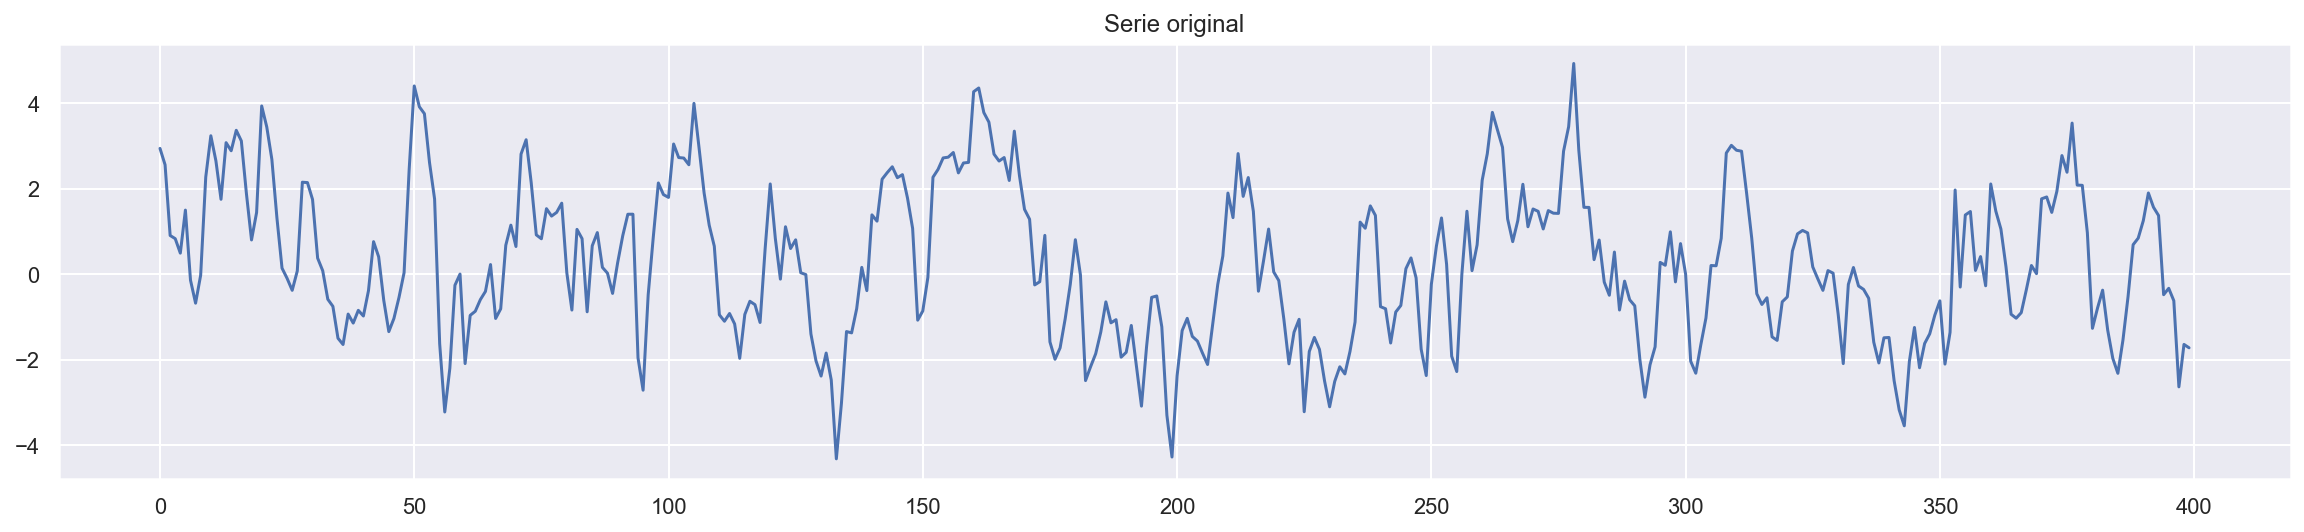

In [2]:
from statsmodels.tsa.arima_process import arma_generate_sample

# Por convenio, a los coeficientes del modelo AR se le cambia el signo. 
ar_coefs = [1,-0.9, 0.1] # Coeficientes del modelo AR(2) (p=2) 
ma_coefs = [1]           # Coeficientes del modelo MA(0) (q=0)

# Generación de los datos (400 puntos)
sample= pd.DataFrame( arma_generate_sample(ar_coefs, ma_coefs, nsample=400))
sample.columns=['y']

# Muetra la serie
fig = plt.figure(figsize=(20,4))
plt.plot(sample)
plt.title('Serie original');

Crea las nuevas características mediante retraso/desplazamiento

In [3]:
sample['x1']=sample['y'].shift()
sample['x2']=sample['y'].shift(2)
sample = sample[['x1','x2','y']]
sample.dropna(inplace=True)
sample.head()

x1        x2         y
2  2.561479  2.944888  0.906262
3  0.906262  2.561479  0.831879
4  0.831879  0.906262  0.493223
5  0.493223  0.831879  1.500492
6  1.500492  0.493223 -0.138607

Entrenamiento/test

In [4]:
X_train = sample.iloc[:200][['x1','x2']]
y_train = sample.iloc[:200]['y']
X_test = sample.iloc[200:][['x1','x2']]
y_test = sample.iloc[200:]['y']

Modelo de regresión lineal y predicción *one-step-ahead*

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train,y_train);

y_train_pred = model.predict(X_train)
print(f'R² (train) {r2_score(y_train, y_train_pred)}')
print(f'MAE (train) {np.sqrt(mean_squared_error(y_train, y_train_pred))}')

y_test_pred = model.predict(X_test)
print(f'R² (test) {r2_score(y_test, y_test_pred)}')
print(f'MAE (test) {np.sqrt(mean_squared_error(y_test, y_test_pred))}')

R² (train) 0.7233888484066868
MAE (train) 0.9744701788504521
R² (test) 0.6557842541953519
MAE (test) 0.9578008886531638


Visualización de la predicción

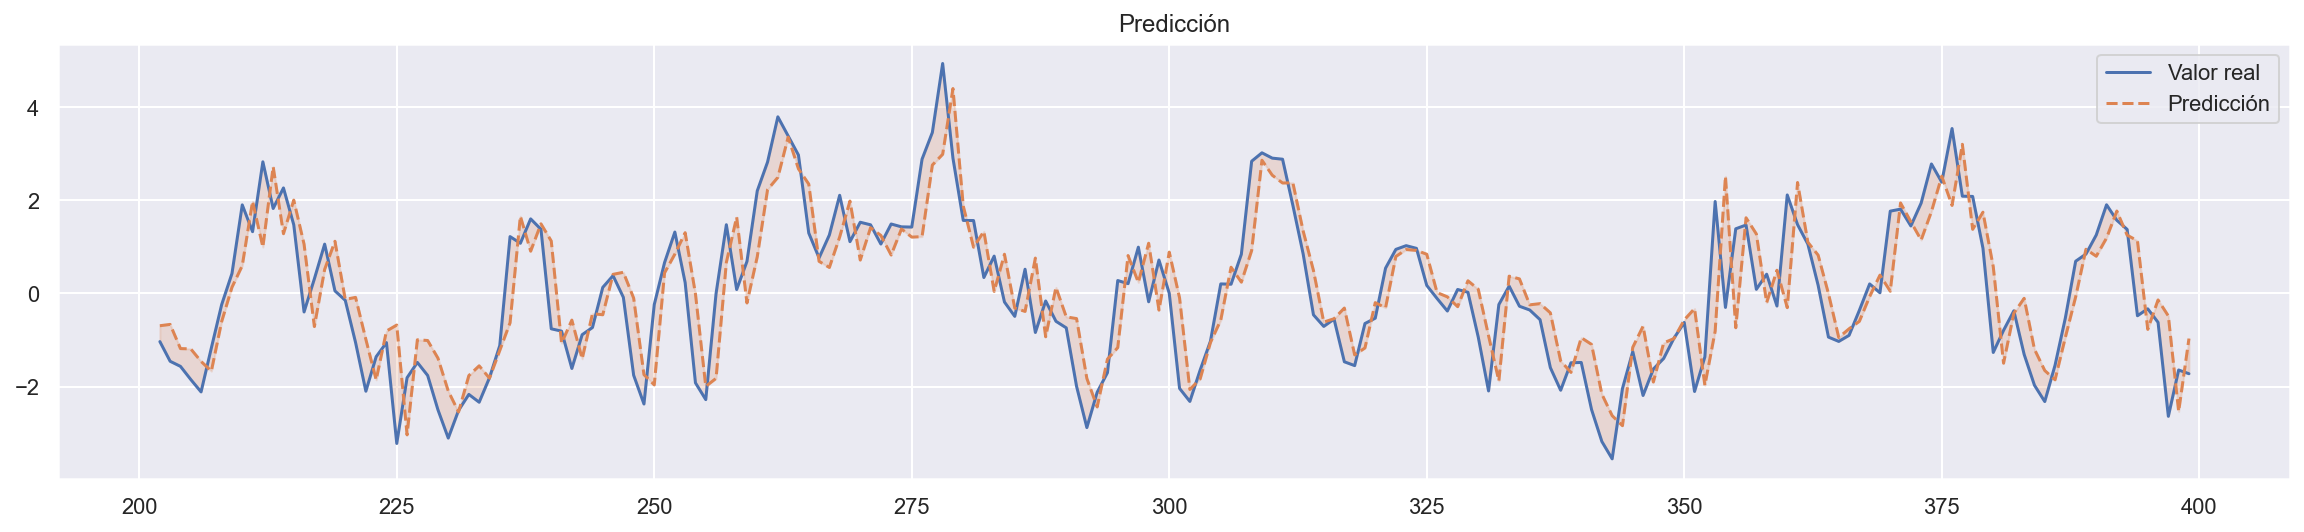

In [6]:
fig = plt.figure(figsize=(20,4))
plt.plot(y_test, label='Valor real');
plt.plot(y_test.index, y_test_pred, label = 'Predicción', linestyle='--');
plt.fill_between(y_test.index, y_test, y_test_pred, alpha=0.2, color=colors[1])
plt.legend();
plt.title('Predicción');

(Los coeficientes corresponden a los utilizados en la simulación)

In [7]:
print(model.coef_)
print(model.intercept_)

[ 1.05328423 -0.25637372]
0.08528106579701666


### <font color="#00586D"> Tendencia / estacional I</font>

In [8]:
water = pd.read_csv('data/water.csv', index_col=0)
water.index = pd.to_datetime(water.index)
water.columns=['Consumo']
water.index.name = 'Fecha'

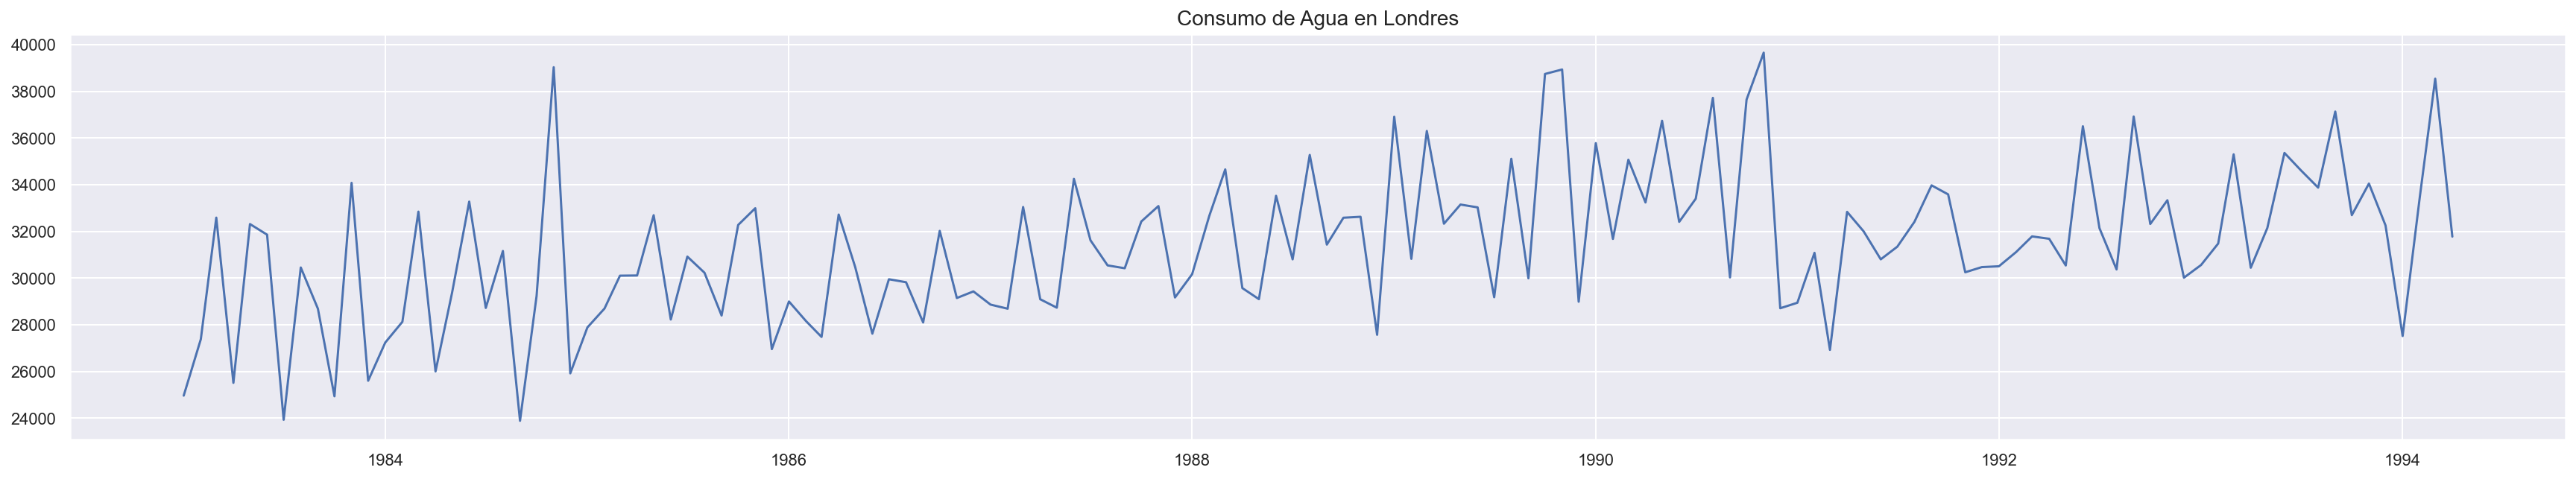

In [9]:
fig, ax = plt.subplots(1,1, figsize=(30,5))
ax.plot(water);
ax.set_title('Consumo de Agua en Londres', fontsize=14);

La función de autocorrelación permite determinar el periodo estacional

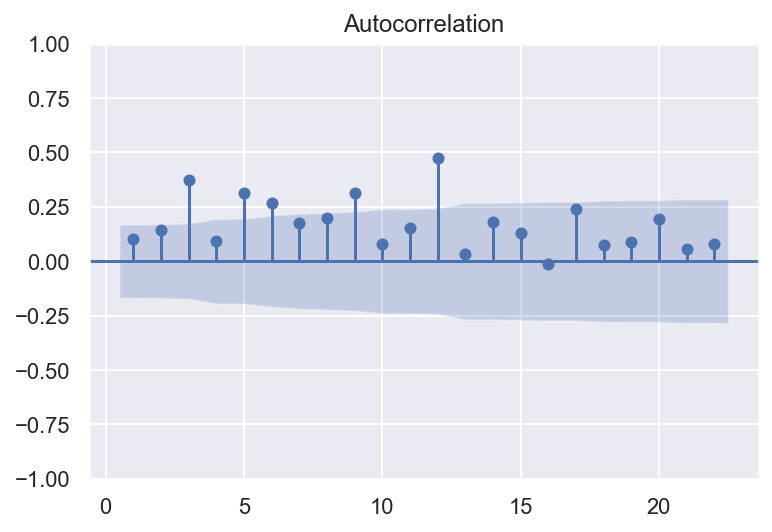

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(water['Consumo'], zero=False);

Se crean las características mediante retrasos. Uno corresponde al día anterior, y otro al periodo estacional.

In [11]:
water['Último']=water['Consumo'].shift()
water['Año atrás']=water['Consumo'].shift(12)

La diferencia puede ser relevante. 

In [12]:
water['Diferencia anual'] = water['Último']-water['Consumo'].diff(13)
water['Diferencia seis meses'] = water['Último']-water['Consumo'].diff(7)
water.dropna(inplace=True)

<div class="alert alert-block alert-danger">

<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
**MUY IMPORTANTE** Fijaos que la diferencia se hace entre el mes anterior y un año/seis meses antes de ese mes. Si utilizásemos `.diff(12)` estaríamos produciendo una **fuga de datos**, ya que para el cálculo de la diferencia del valor actual con el valor hace un año se utiliza... el propio valor actual.
</div>

In [13]:
water.head()

Consumo   Último  Año atrás  Diferencia anual  \
Fecha                                                       
1984-02-01    28126  27238.0    27380.0           24075.0   
1984-03-01    32845  28126.0    32588.0           22661.0   
1984-04-01    26001  32845.0    25511.0           39432.0   
1984-05-01    29377  26001.0    32313.0           22135.0   
1984-06-01    33275  29377.0    31858.0           28415.0   

            Diferencia seis meses  
Fecha                              
1984-02-01                23041.0  
1984-03-01                25733.0  
1984-04-01                35532.0  
1984-05-01                21560.0  
1984-06-01                30180.0

Entrenamiento/test

In [14]:
features = ['Último','Año atrás','Diferencia anual','Diferencia seis meses']
X_train = water.iloc[:80][features]
y_train = water.iloc[:80]['Consumo']
X_test = water.iloc[80:][features]
y_test = water.iloc[80:]['Consumo']

In [15]:
model = LinearRegression()
model.fit(X_train,y_train);

y_train_pred = model.predict(X_train)
print(f'R² (train) {r2_score(y_train, y_train_pred)}')
print(f'MAE (train) {np.sqrt(mean_squared_error(y_train, y_train_pred))}')

y_test_pred = model.predict(X_test)
print(f'R² (test) {r2_score(y_test, y_test_pred)}')
print(f'MAE (test) {np.sqrt(mean_squared_error(y_test, y_test_pred))}')

R² (train) 0.7298800508408765
MAE (train) 1605.945236377439
R² (test) 0.5280188540891859
MAE (test) 1906.448601714048


Visualización de la predicción

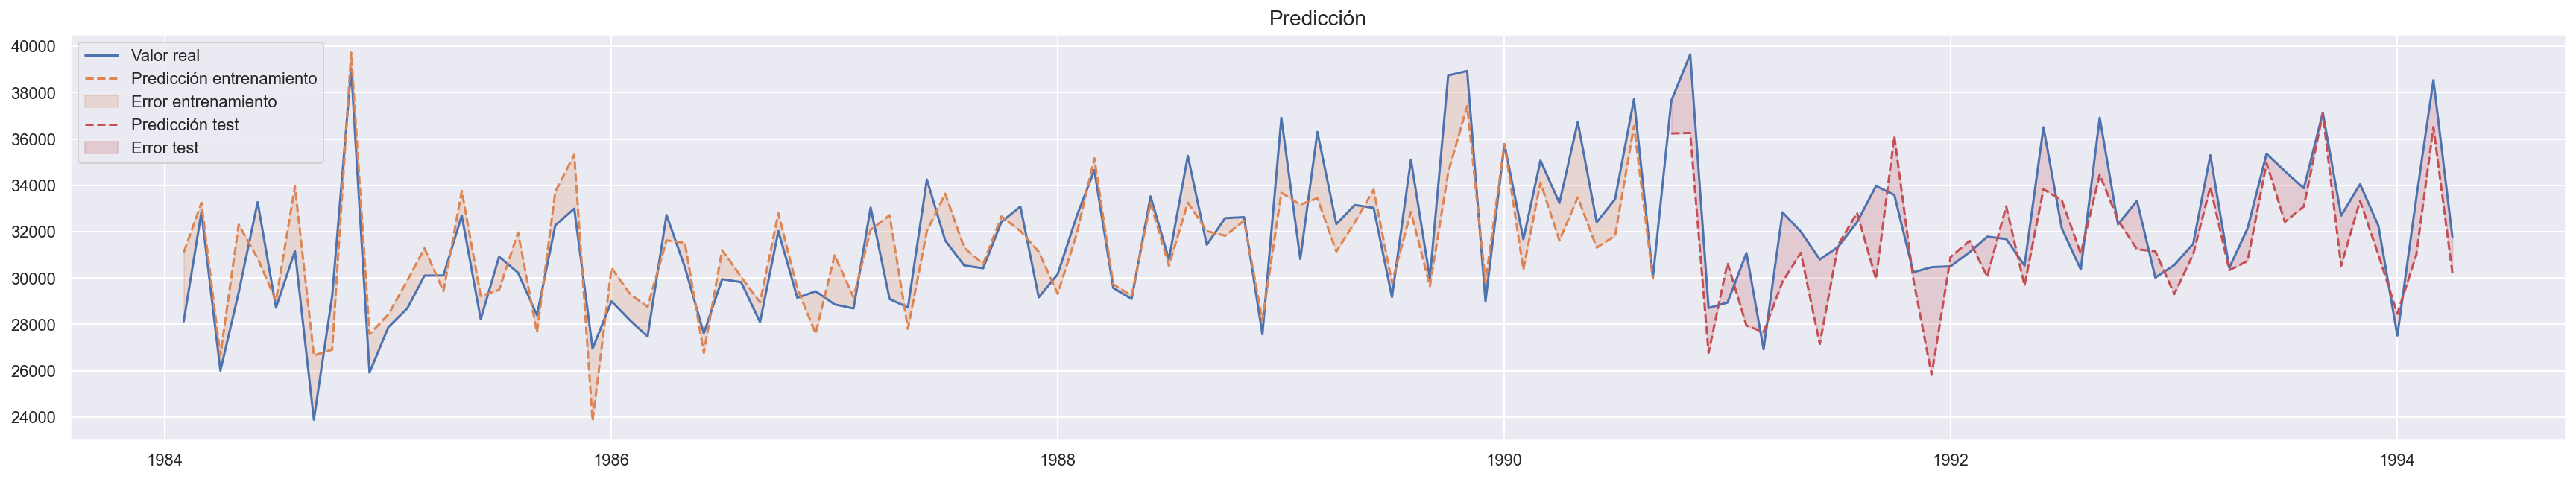

In [16]:
fig = plt.figure(figsize=(30,5))

# Serie original
plt.plot(water.index, water['Consumo'], label='Valor real');
# Entrenamiento, 
plt.plot(y_train.index, y_train_pred, label = 'Predicción entrenamiento', color=colors[1], linestyle='--');
plt.fill_between(y_train.index, y_train, y_train_pred, alpha=0.2,  color=colors[1], label='Error entrenamiento')
#Test
plt.plot(y_test.index, y_test_pred, label = 'Predicción test', color=colors[3], linestyle='--');
plt.fill_between(y_test.index, y_test, y_test_pred, alpha=0.2,  color=colors[3], label='Error test')

plt.title('Predicción', fontsize=14);
plt.legend();

### <font color="#00586D"> Tendencia / estacional II</font>

In [17]:
milk_production = pd.read_csv('data/milk_production.csv', index_col=0)
milk_production.index = pd.to_datetime(milk_production.index)
milk_production.columns=['Libras por vaca']
milk_production.index.name = 'Fecha'

Se busca el periodo estacional mediante la función de autocorrelación

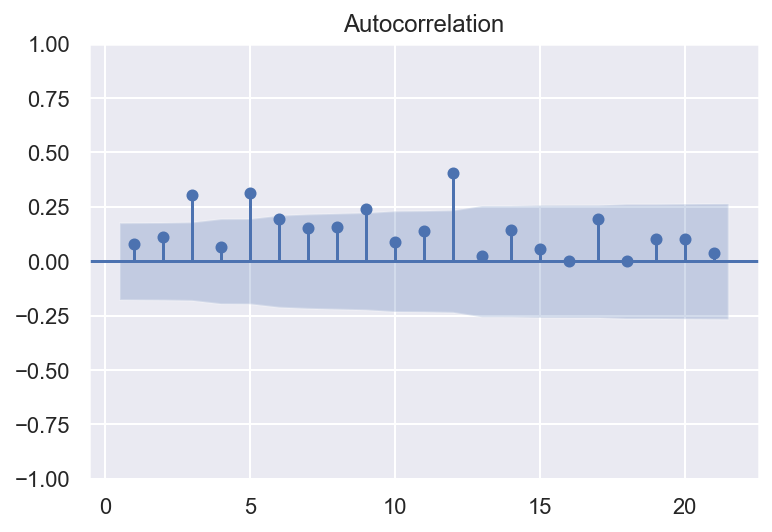

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(water['Consumo'], zero=False);

Crea las características de forma similar al ejemplo anterior

In [19]:
milk_production['Último']=milk_production['Libras por vaca'].shift()
milk_production['Año atrás']=milk_production['Libras por vaca'].shift(12)
milk_production['Cambio anual'] = milk_production['Último']-milk_production['Libras por vaca'].diff(13)
milk_production['Cambio seis meses'] = milk_production['Último']-milk_production['Libras por vaca'].diff(7)
milk_production.dropna(inplace=True)
milk_production.head()

Libras por vaca  Último  Año atrás  Cambio anual  \
Fecha                                                          
1963-02-01            566.0   600.0      561.0         623.0   
1963-03-01            653.0   566.0      640.0         474.0   
1963-04-01            673.0   653.0      656.0         620.0   
1963-05-01            742.0   673.0      727.0         587.0   
1963-06-01            716.0   742.0      697.0         753.0   

            Cambio seis meses  
Fecha                          
1963-02-01              674.0  
1963-03-01              512.0  
1963-04-01              548.0  
1963-05-01              508.0  
1963-06-01              579.0

Entrenamiento/test

In [20]:
features = ['Último','Año atrás','Cambio anual','Cambio seis meses']

X_train = milk_production.iloc[:120][features]
y_train = milk_production.iloc[:120]['Libras por vaca']
X_test = milk_production.iloc[120:][features]
y_test = milk_production.iloc[120:]['Libras por vaca']

Entrena un modelo de regresión lineal y muestra los resultados

In [21]:
model = LinearRegression()
model.fit(X_train,y_train);

y_train_pred = model.predict(X_train)
print(f'R² (train) {r2_score(y_train, y_train_pred)}')
print(f'MAE (train) {np.sqrt(mean_squared_error(y_train, y_train_pred))}')

y_test_pred = model.predict(X_test)
print(f'R² (test) {r2_score(y_test, y_test_pred)}')
print(f'MAE (test) {np.sqrt(mean_squared_error(y_test, y_test_pred))}')

R² (train) 0.9973639339800453
MAE (train) 4.557363710322293
R² (test) 0.9950696547473108
MAE (test) 4.259054961343219


Visualiza los resultados

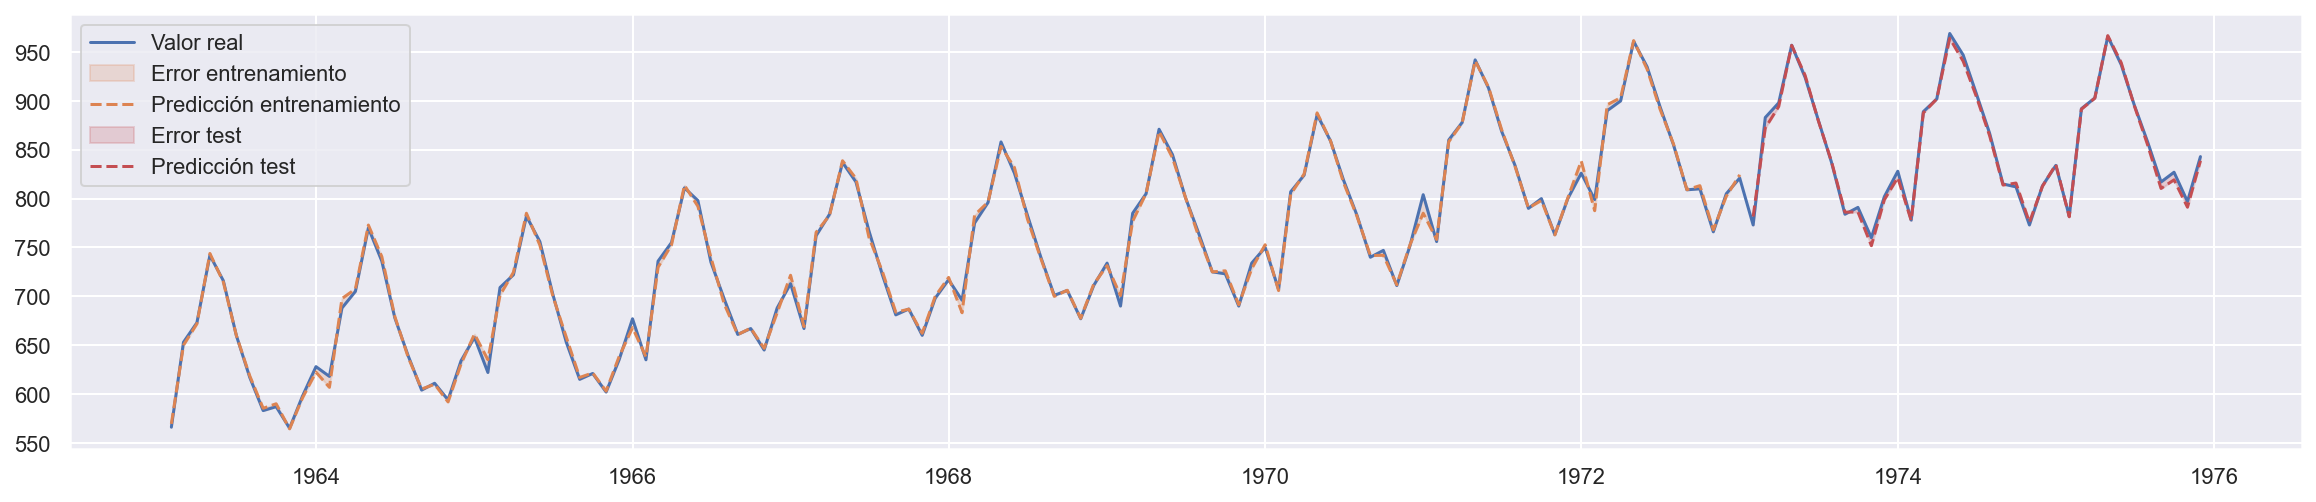

In [22]:
fig = plt.figure(figsize=(20,4))
# Serie original
plt.plot(milk_production.index, milk_production['Libras por vaca'], label='Valor real');
# Entrenamiento
plt.fill_between(y_train.index, y_train, y_train_pred, alpha=0.2,  color=colors[1], label='Error entrenamiento')
plt.plot(y_train.index, y_train_pred, label = 'Predicción entrenamiento', color=colors[1], linestyle='--');
# Test
plt.fill_between(y_test.index, y_test, y_test_pred, alpha=0.2,  color=colors[3], label='Error test')
plt.plot(y_test.index, y_test_pred, label = 'Predicción test', color=colors[3], linestyle='--');
plt.legend();

### <font color="#00586D"> Ejemplo: variables exógenas</font>

Este ejemplo es sintético

In [23]:
data=pd.read_csv('data/ml_example.csv', index_col=0)
print(f'Número de ejemplos: {len(data)}')

data.head()

Número de ejemplos: 800


x1    x2    x3      y
t                            
0.10  2.68  0.23  1.53   1.23
0.97  2.13  4.95  0.37   2.89
2.02  0.37  3.56  3.82 -21.89
3.09  2.26  1.19  4.90  -9.56
3.99  2.33  2.62  2.55   0.39

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: En este caso, es posible utilizar marcas de tiempo que no sean equidistantes.
</div>



Visualiza las variables salida $Y$ y exógenas $X_1, X_2, X_3$.

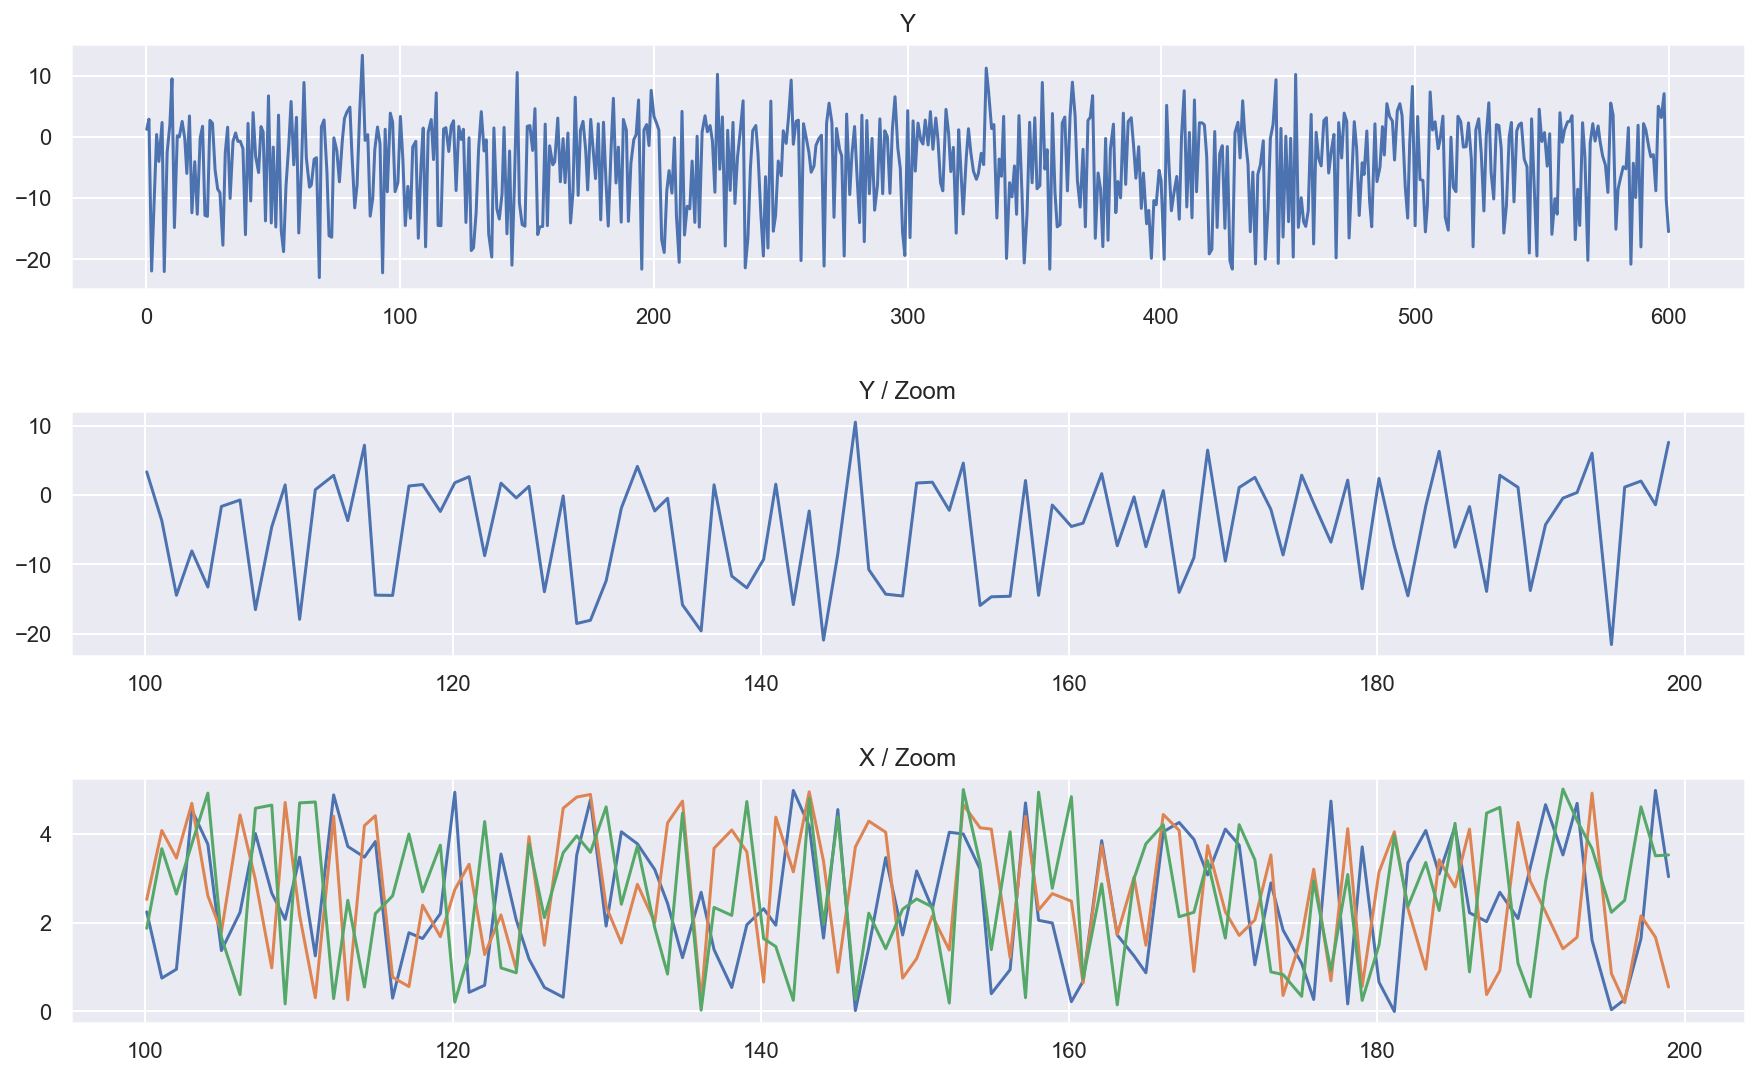

In [24]:
fig, ax = plt.subplots(3,1, figsize=(15,9))

# Variable y
ax[0].plot(data['y'][:600])
ax[0].set_title('Y')

# Variable y (zoom)
ax[1].plot(data.iloc[100:200]['y'])
ax[1].set_title('Y / Zoom')

# Variables de entrada
ax[2].plot(data.iloc[100:200]['x1'])
ax[2].plot(data.iloc[100:200]['x2'])
ax[2].plot(data.iloc[100:200]['x3'])
ax[2].set_title('X / Zoom')

plt.subplots_adjust(hspace=0.5);

### <font color="#00586D"> Pronóstico mediante regresión lineal</font>

Como variable de entrada para el pronóstico de $y_t$ se incluye $y_{t-1}$.

In [25]:
data['y-1']=data['y'].shift()
data.dropna(inplace=True)

In [26]:
X_train = data.iloc[:600].drop(columns='y')
y_train = data.iloc[:600]['y']
X_test = data.iloc[600:].drop(columns='y')
y_test = data.iloc[600:]['y']

In [27]:
X_train.head()

x1    x2    x3    y-1
t                            
0.97  2.13  4.95  0.37   1.23
2.02  0.37  3.56  3.82   2.89
3.09  2.26  1.19  4.90 -21.89
3.99  2.33  2.62  2.55  -9.56
4.89  1.72  0.19  1.88   0.39

#### <font color="#00586D"> Regresión a partir de las variables de entrada del momento actual</font>

In [28]:
model = LinearRegression()
model.fit(X_train,y_train);

y_train_pred = model.predict(X_train)
print(f'R² (train) {r2_score(y_train, y_train_pred)}')
print(f'MAE (train) {np.sqrt(mean_squared_error(y_train, y_train_pred))}')

y_test_pred = model.predict(X_test)
print(f'R² (test) {r2_score(y_test, y_test_pred)}')
print(f'MAE (test) {np.sqrt(mean_squared_error(y_test, y_test_pred))}')

R² (train) 0.025195966087977806
MAE (train) 7.642362300571255
R² (test) -0.01462518407820057
MAE (test) 7.991083228189023


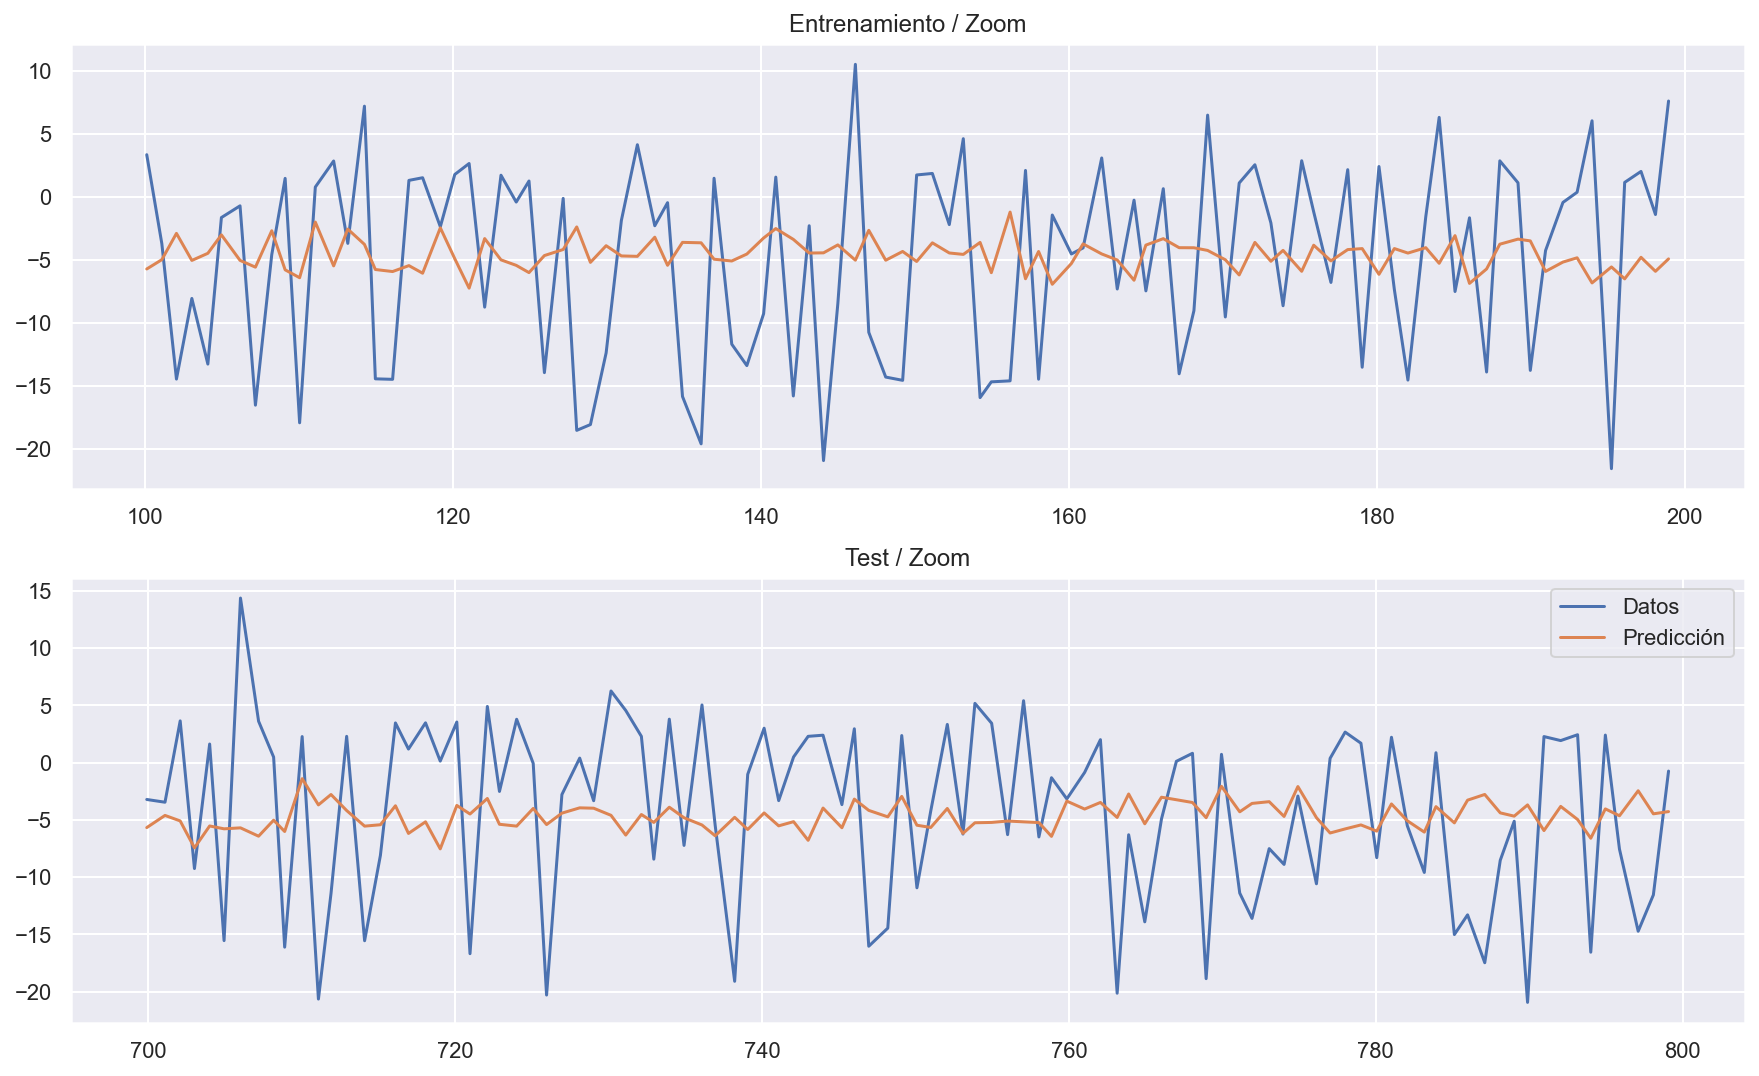

In [29]:
fig, ax = plt.subplots(2,1, figsize=(15,9))

ax[0].plot(y_train[100:200], label = 'Datos')
ax[0].plot(y_train[100:200].index, y_train_pred[100:200], label = 'Predicción')
ax[0].set_title(f'Entrenamiento / Zoom')

ax[1].plot(y_test.iloc[-100:], label = 'Datos')
ax[1].plot(y_test.iloc[-100:].index, y_test_pred[-100:], label = 'Predicción')
ax[1].set_title(f'Test / Zoom')

ax[1].legend()
plt.subplots_adjust(hspace=0.2);

### <font color="#00586D"> Creación de características y regresión lineal</font>

Para la predicción de $y_t$ de utilizan los retrasos y diferencias $1\ldots5$ de las variables de entrada, como de la marca de tiempo. Observad que en este caso se dan por conocidos los valores de $X_1, X_2, X_3$ en el instante $t$, pero no $y_t$.

In [30]:
data.reset_index(inplace=True)

for lag in range(1,5):    
    data[f't-{lag}']=data['t'].shift(lag)             
    data[f'$\Delta_{lag}$t']=data['t'].diff(lag)       
    
    data[f'x1-{lag}']=data['x1'].shift(lag)
    data[f'$\Delta_{lag}$x1']=data['x1'].diff(lag)
    
    data[f'x2-{lag}']=data['x2'].shift(lag)
    data[f'$\Delta_{lag}$x2']=data['x2'].diff(lag)
    
    data[f'x3-{lag}']=data['x3'].shift(lag)
    data[f'$\Delta_{lag}$x3']=data['x3'].diff(lag)

data.dropna(inplace=True)
data.head()

t    x1    x2    x3      y    y-1   t-1  $\Delta_1$t  x1-1  \
4  4.89  1.72  0.19  1.88  -4.01   0.39  3.99         0.90  2.33   
5  6.15  2.33  4.97  2.93   2.35  -4.01  4.89         1.26  1.72   
6  7.00  4.65  3.00  2.86 -21.98   2.35  6.15         0.85  2.33   
7  8.14  0.41  0.86  3.62  -2.53 -21.98  7.00         1.14  4.65   
8  9.21  4.71  0.09  2.61   1.95  -2.53  8.14         1.07  0.41   

   $\Delta_1$x1  ...  x3-3  $\Delta_3$x3   t-4  $\Delta_4$t  x1-4  \
4         -0.61  ...  3.82         -1.94  0.97         3.92  2.13   
5          0.61  ...  4.90         -1.97  2.02         4.13  0.37   
6          2.32  ...  2.55          0.31  3.09         3.91  2.26   
7         -4.24  ...  1.88          1.74  3.99         4.15  2.33   
8          4.30  ...  2.93         -0.32  4.89         4.32  1.72   

   $\Delta_4$x1  x2-4  $\Delta_4$x2  x3-4  $\Delta_4$x3  
4         -0.41  4.95         -4.76  0.37          1.51  
5          1.96  3.56          1.41  3.82         -0.89  
6          2.39  1.19          1.81  4.90         -2.04  
7         -1.92  2.62         -1.76  2.55          1.07  
8          2.99  0.19         -0.10  1.88          0.73  

[5 rows x 38 columns]

Entrena el modelo

In [31]:
X_train = data.iloc[:600].drop(columns='y')
y_train = data.iloc[:600]['y']
X_test = data.iloc[600:].drop(columns='y')
y_test = data.iloc[600:]['y']
X_train

t    x1    x2    x3    y-1     t-1  $\Delta_1$t  x1-1  $\Delta_1$x1  \
4      4.89  1.72  0.19  1.88   0.39    3.99         0.90  2.33         -0.61   
5      6.15  2.33  4.97  2.93  -4.01    4.89         1.26  1.72          0.61   
6      7.00  4.65  3.00  2.86   2.35    6.15         0.85  2.33          2.32   
7      8.14  0.41  0.86  3.62 -21.98    7.00         1.14  4.65         -4.24   
8      9.21  4.71  0.09  2.61  -2.53    8.14         1.07  0.41          4.30   
..      ...   ...   ...   ...    ...     ...          ...   ...           ...   
599  599.96  0.50  1.41  1.28 -10.19  599.03         0.93  1.04         -0.54   
600  600.91  4.68  3.03  1.22 -15.47  599.96         0.95  0.50          4.18   
601  602.08  2.02  4.88  1.01   0.89  600.91         1.17  4.68         -2.66   
602  602.95  3.45  4.93  1.88  -5.58  602.08         0.87  2.02          1.43   
603  604.19  2.17  3.34  3.04 -20.25  602.95         1.24  3.45         -1.28   

     x2-1  ...  x3-3  $\Delta_3$x3     t-4  $\Delta_4$t  x1-4  $\Delta_4$x1  \
4    2.62  ...  3.82         -1.94    0.97         3.92  2.13         -0.41   
5    0.19  ...  4.90         -1.97    2.02         4.13  0.37          1.96   
6    4.97  ...  2.55          0.31    3.09         3.91  2.26          2.39   
7    3.00  ...  1.88          1.74    3.99         4.15  2.33         -1.92   
8    0.86  ...  2.93         -0.32    4.89         4.32  1.72          2.99   
..    ...  ...   ...           ...     ...          ...   ...           ...   
599  4.25  ...  2.63         -1.35  595.91         4.05  4.39         -3.89   
600  1.41  ...  4.51         -3.29  597.10         3.81  4.10          0.58   
601  3.03  ...  0.77          0.24  598.20         3.88  1.55          0.47   
602  4.88  ...  1.28          0.60  599.03         3.92  1.04          2.41   
603  4.93  ...  1.22          1.82  599.96         4.23  0.50          1.67   

     x2-4  $\Delta_4$x2  x3-4  $\Delta_4$x3  
4    4.95         -4.76  0.37          1.51  
5    3.56          1.41  3.82         -0.89  
6    1.19          1.81  4.90         -2.04  
7    2.62         -1.76  2.55          1.07  
8    0.19         -0.10  1.88          0.73  
..    ...           ...   ...           ...  
599  1.25          0.16  2.83         -1.55  
600  0.66          2.37  2.63         -1.41  
601  3.62          1.26  4.51         -3.50  
602  4.25          0.68  0.77          1.11  
603  1.41          1.93  1.28          1.76  

[600 rows x 37 columns]

In [32]:
model = LinearRegression()
model.fit(X_train,y_train);

y_train_pred = model.predict(X_train)
print(f'R² (train) {r2_score(y_train, y_train_pred)}')
print(f'MAE (train) {np.sqrt(mean_squared_error(y_train, y_train_pred))}')

y_test_pred = model.predict(X_test)
print(f'R² (test) {r2_score(y_test, y_test_pred)}')
print(f'MAE (test) {np.sqrt(mean_squared_error(y_test, y_test_pred))}')

R² (train) 0.9066185466992385
MAE (train) 2.3709809246602145
R² (test) 0.911050201233288
MAE (test) 2.332807645270907


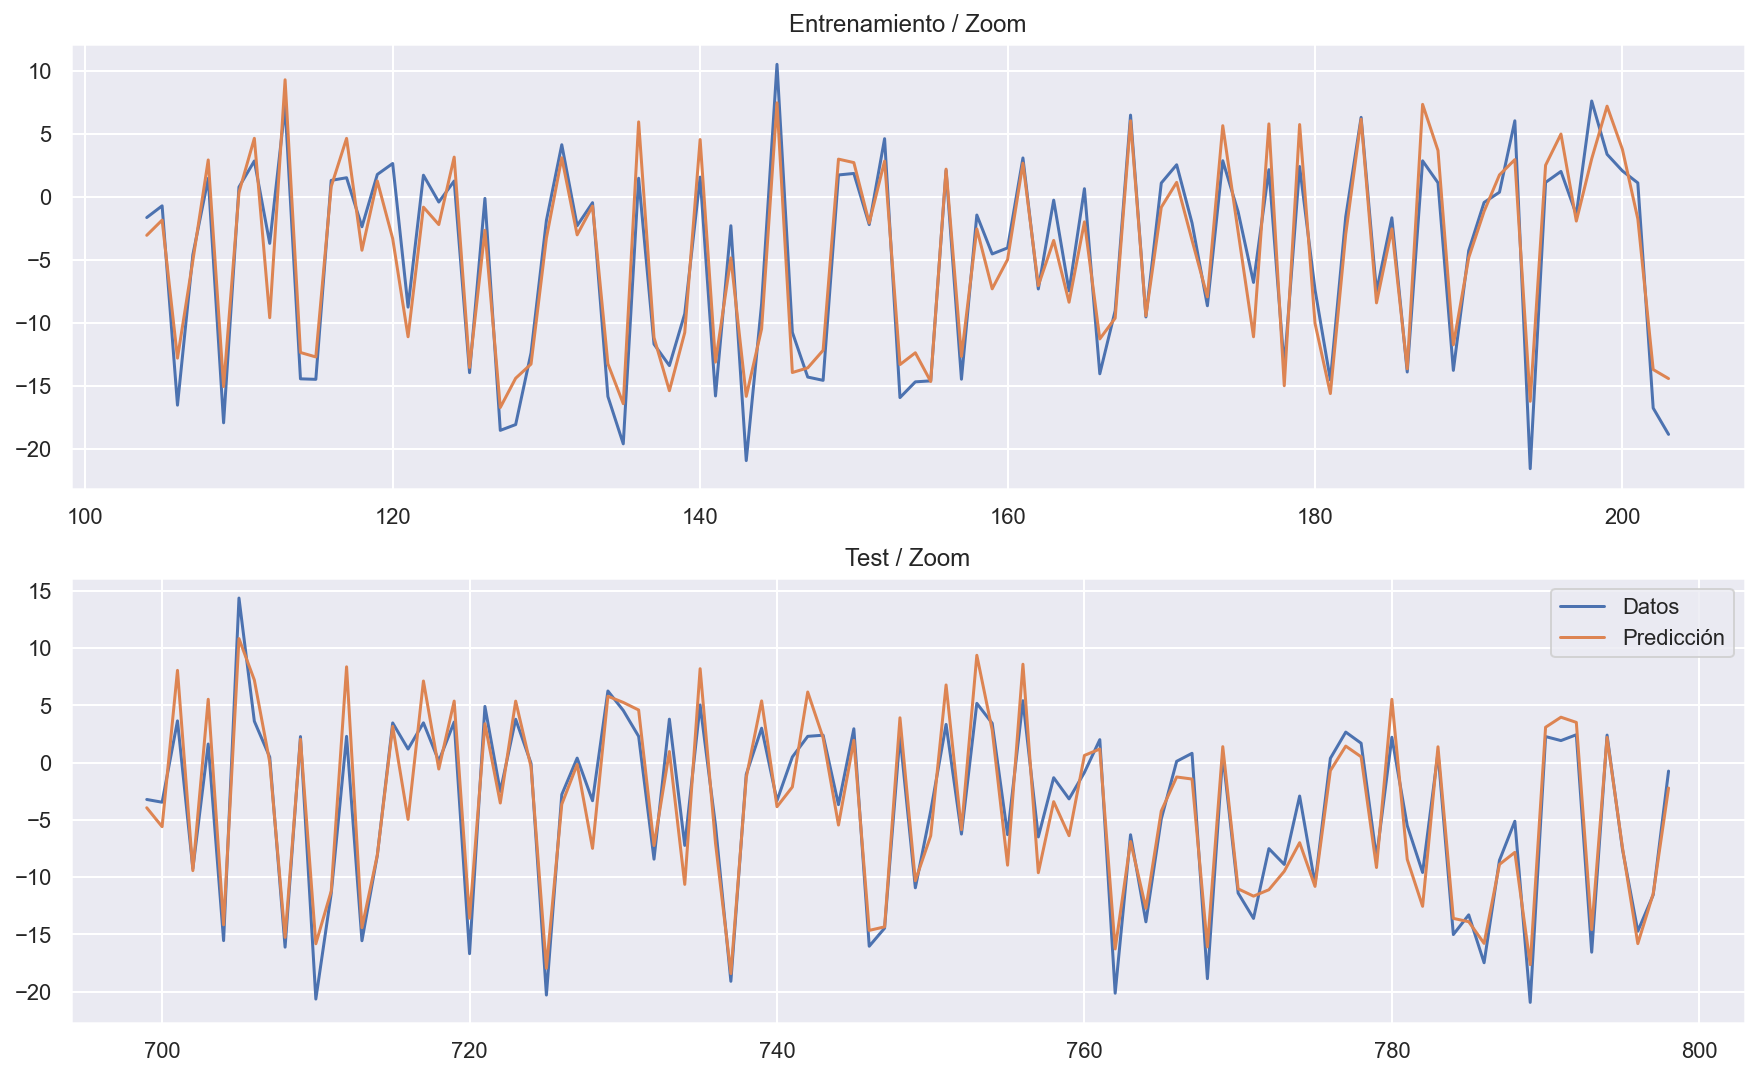

In [33]:
fig, ax = plt.subplots(2,1, figsize=(15,9))

ax[0].plot(y_train[100:200], label = 'Datos')
ax[0].plot(y_train[100:200].index, y_train_pred[100:200], label = 'Predicción')
ax[0].set_title(f'Entrenamiento / Zoom')

ax[1].plot(y_test.iloc[-100:], label = 'Datos')
ax[1].plot(y_test.iloc[-100:].index, y_test_pred[-100:], label = 'Predicción')
ax[1].set_title(f'Test / Zoom')
ax[1].legend()

plt.subplots_adjust(hspace=0.2);

### <font color="#00586D"> Predicción con sktime </font>

<div class="alert alert-block alert-danger">

<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
**MUY IMPORTANTE** Como la librería es nueva, sufre cambios importantes. Es necesario instalar la última versión (de este mes).
</div>

In [34]:
#! pip install sktime

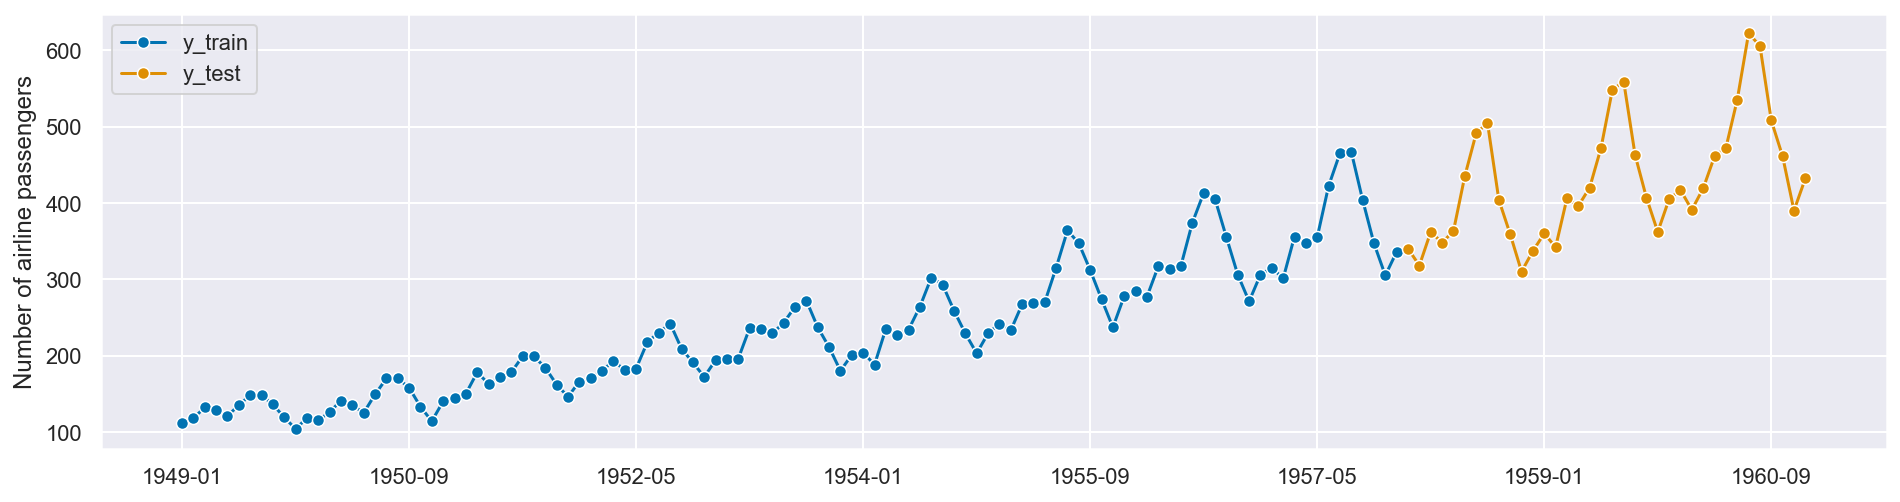

In [35]:
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split

# carga el conjunto de datos de pasajeros en líneas aereas
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

En este ejemplo se lleva a cabo el pronóstico con reducción (ventana deslizante) y regresión lineal. No se crean características. Es parecido a lo visto anteriormente.

0.1091398905478952

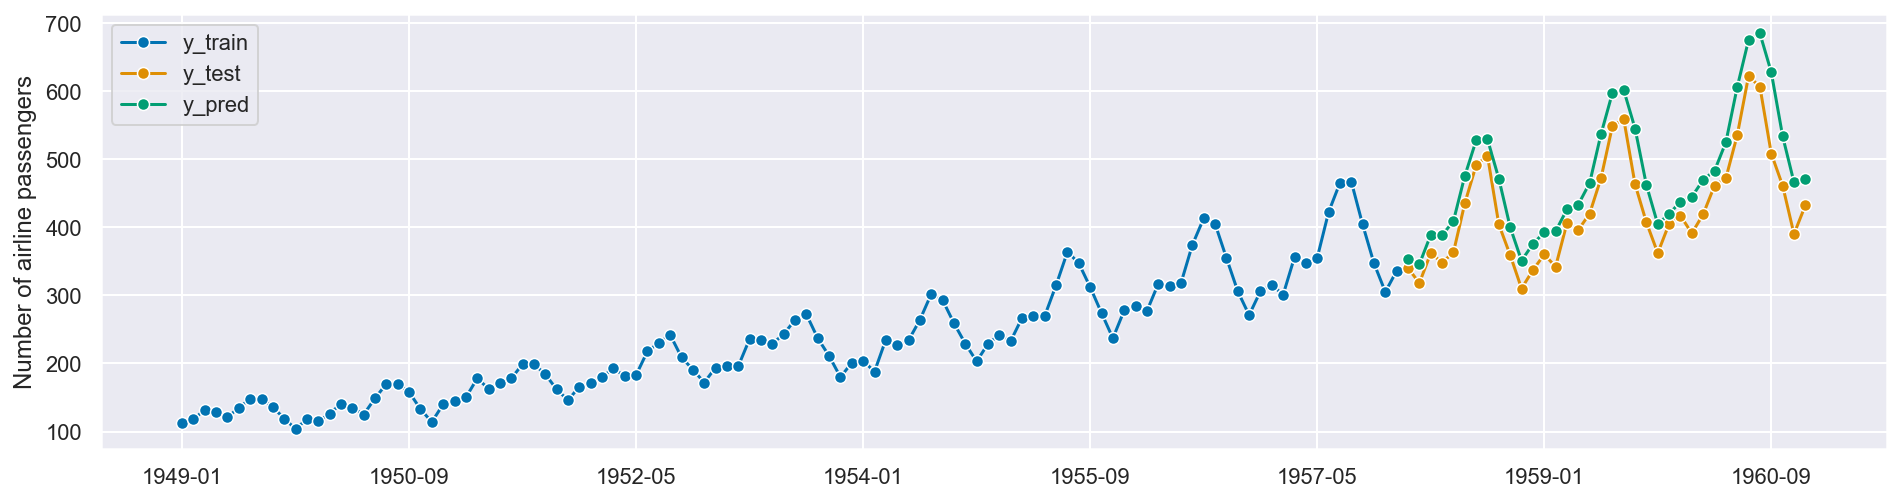

In [36]:
from sktime.forecasting.compose import RecursiveTabularRegressionForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

estimator = LinearRegression()

forecaster = RecursiveTabularRegressionForecaster(estimator=estimator, window_length=12)
forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

#### <font color="#00586D"> Creación de características</font>

En este ejemplo se utiliza creación de características con ventana deslizante + un arbol de regresión para hacer la predicción. 

In [37]:
#!pip install tsfresh

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline

from sktime.datasets import load_airline


from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_airline()
y_train, y_test = temporal_train_test_split(y)

regressor = make_pipeline(
    TSFreshFeatureExtractor(show_warnings=False, disable_progressbar=True),
    DecisionTreeRegressor(),
)

forecaster = make_reduction(
    regressor, scitype="time-series-regressor", window_length=12
)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

0.16334227149621522

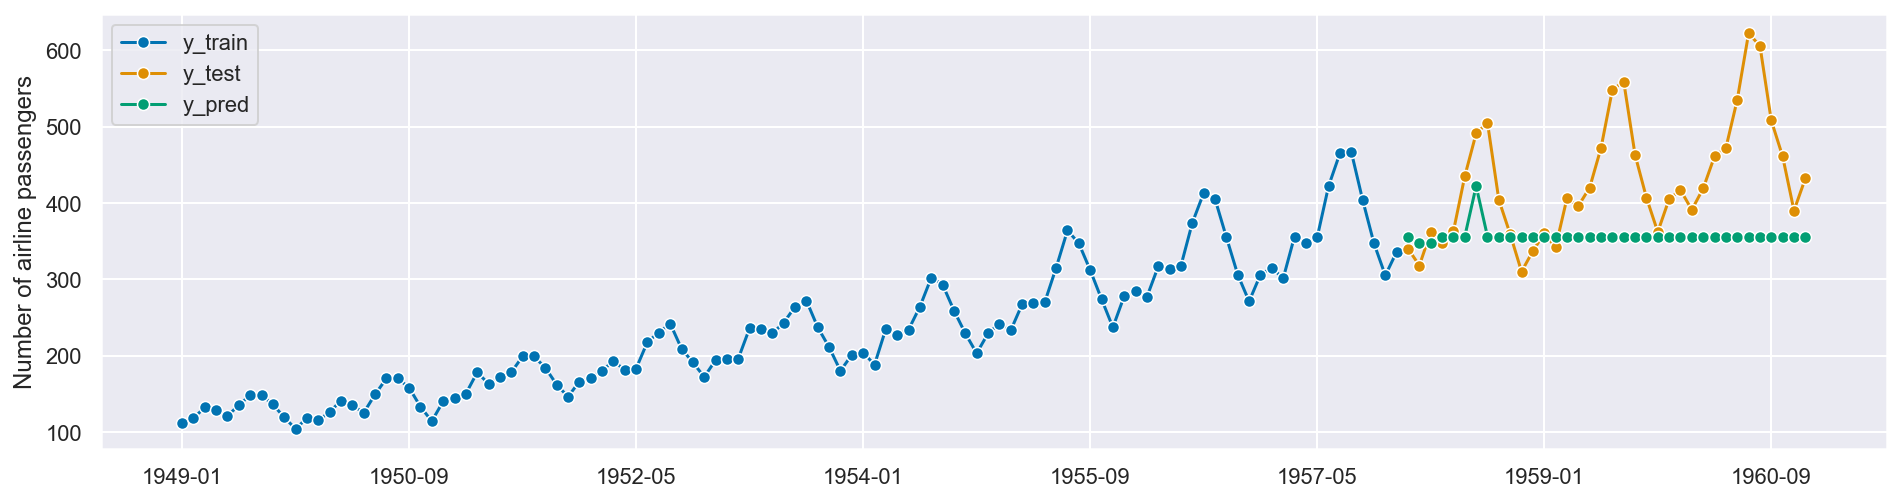

In [39]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section2"></a> 
## <font color="#00586D"> 2. Comparación de series: Dynamic Time Warping</font>
<br>

La versión original de este ejemplo, y explicaciones adicionales, pueden leerse [(aquí)](https://databricks.com/blog/2019/04/30/understanding-dynamic-time-warping.html). Una aplicación (además del uso de MLFlow) [(aquí)](https://databricks.com/blog/2019/04/30/using-dynamic-time-warping-and-mlflow-to-detect-sales-trends.html).

In [40]:
audio_files = ['data/1.wav','data/2.wav','data/3.wav','data/4.wav']
phrases = ['Doors and corners, kid. That’s where they get you.',
           'Doors and corners, kid. That’s where they get you.',
           'You walk into a room too fast,the room eats you',
           'Doors and corners, kid. That’s where they get you.']

nclips = 4

In [41]:
import IPython.display as ipd

clip = 3
print(phrases[clip])
ipd.Audio(audio_files[clip]) 

Doors and corners, kid. That’s where they get you.


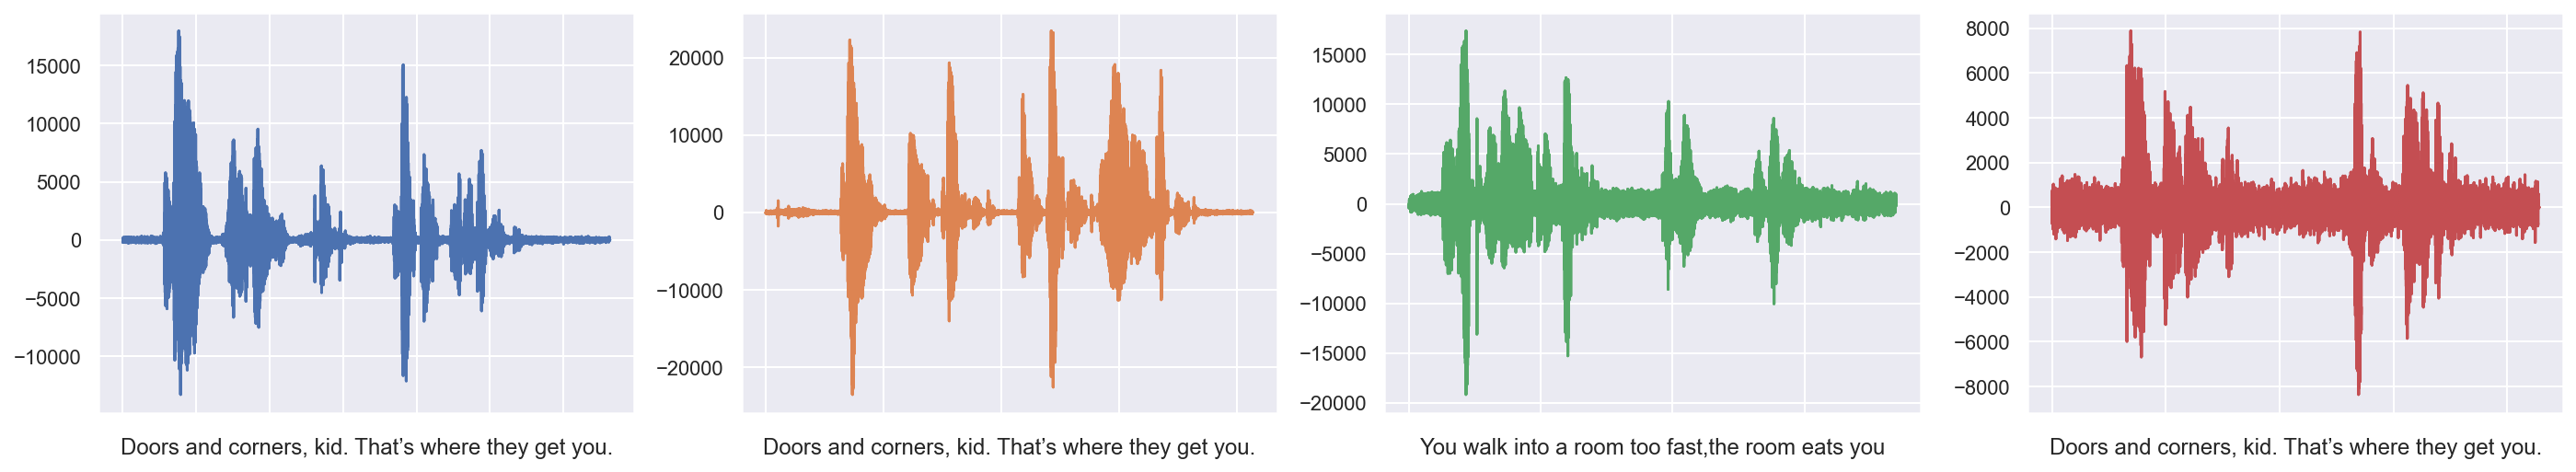

In [42]:
import warnings
warnings.filterwarnings('ignore')

from scipy.io import wavfile
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

# Read stored audio files for comparison
data = [None]*nclips

fig, ax = plt.subplots(1,4, figsize=(24,4))

for i in range(4):
    _, data[i] = wavfile.read(audio_files[i])
    ax[i].plot(data[i], color=colors[i])
    ax[i].set_xticklabels([i])
    ax[i].set_xlabel(phrases[i])

In [43]:
#!pip install --upgrade fastdtw

In [44]:
# Por algún motivo, este algoritmo funciona de forma muy lenta (antes no era así)

#from fastdtw import fastdtw

#for i in range(1,nclips):
#    distance = fastdtw(data[0], data[i])[0]
#    print(f"La distancia entre 0 y {i:d} es {distance:.2f}")

In [45]:
from sktime.distances import dtw_distance

for i in range(1,nclips):
    distance = dtw_distance(data[0], data[i])
    print(f"La distancia entre 0 y {i:d} es {distance:.2f}")

La distancia entre 0 y 1 es 6388491083794.00
La distancia entre 0 y 2 es 3569414694688.00
La distancia entre 0 y 3 es 2261478788656.00


Puede verse que la distancia entre 0 y 1 es mayor que la distancia entre 0 y 2. Esto se debe a la entonación.

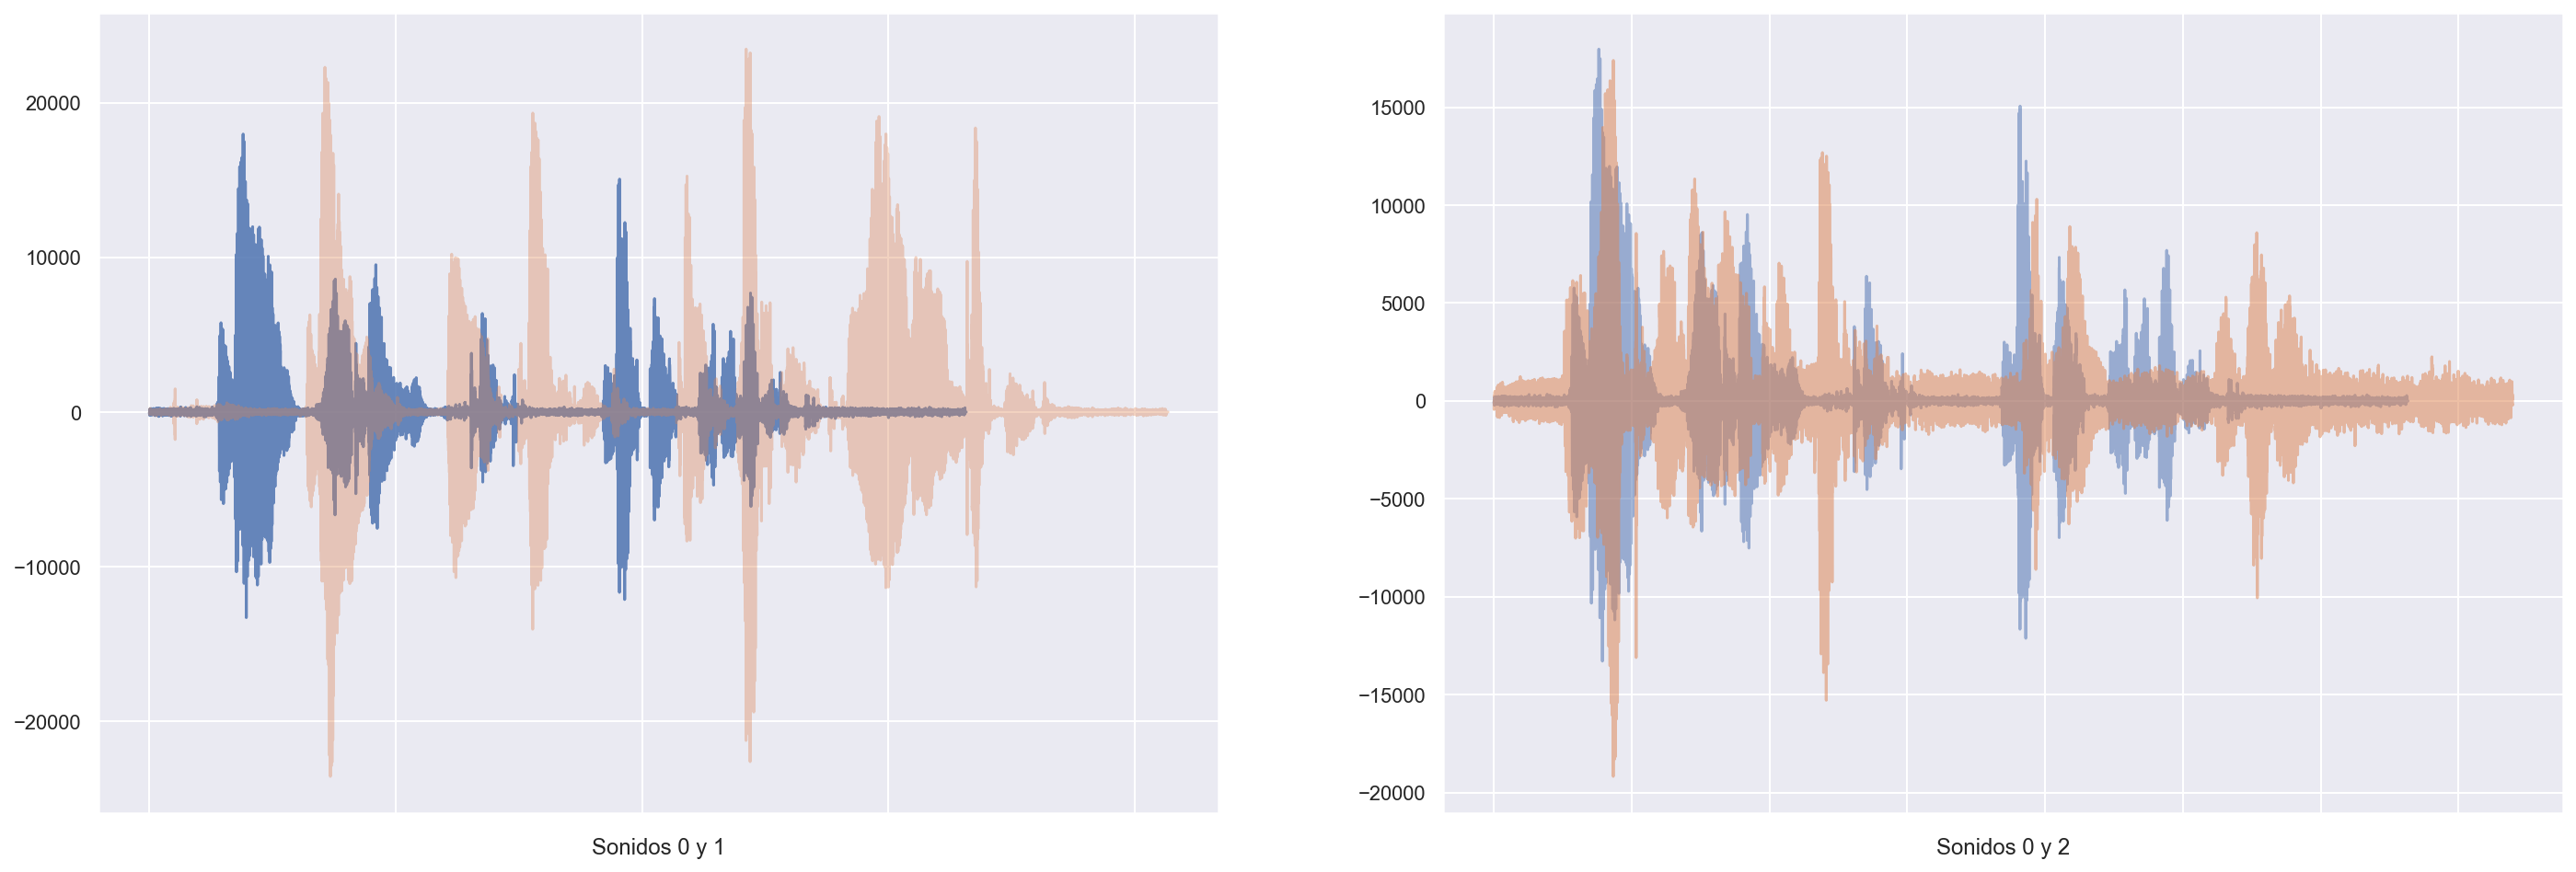

In [46]:
fig, ax = plt.subplots(1,2, figsize=(24,8))
ax[0].plot(data[0], alpha=0.6, color=colors[0])
ax[0].plot(data[1], alpha=0.2, color=colors[1])
ax[0].set_xticklabels([])
ax[0].set_xlabel("Sonidos 0 y 1");

ax[1].plot(data[0], alpha=0.3, color=colors[0])
ax[1].plot(data[2], alpha=0.3, color=colors[1])
ax[1].set_xticklabels([])
ax[1].set_xlabel("Sonidos 0 y 2");

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section3"></a> 
## <font color="#00586D"> 3. Aprendizaje supervisado con series</font>
<br>


En este problema [https://timeseriesclassification.com/description.php?Dataset=FordA](enlace) cada serie corresponde al sonido de un subsistema de un coche. La refleja si se presenta o no una determinada condición.  

Lee los datos en el formato de `sktime`. Este problema corresponde al sonido de un subsistema de un coche. 

In [47]:
from sktime.datasets import load_from_tsfile_to_dataframe

X_train, y_train = load_from_tsfile_to_dataframe('data/FordA_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe('data/FordA_TEST.ts')

En el formato que utiliza `sktime`, cada celda almacena una Serie.

**Nota:** Obviamente, tendrán sus motivos para haberlo hecho así, aunque no parece un formato cómodo.

In [48]:
X_train.head()

dim_0
0  0     -0.797172
1     -0.664392
2     -0.37301...
1  0      0.804855
1      0.634629
2      0.37347...
2  0      0.727985
1      0.111284
2     -0.49912...
3  0     -0.234439
1     -0.502157
2     -0.73248...
4  0     -0.171328
1     -0.062285
2      0.23582...

### <font color="#00586D"> Datos tabulados</font>

Los convierte a datos tabulares estándar. Cada columna representa un instante de tiempo.

In [49]:
from sktime.datatypes._panel._convert import from_nested_to_2d_array

X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)

X_test

dim_0__0  dim_0__1  dim_0__2  dim_0__3  dim_0__4  dim_0__5  dim_0__6  \
0    -0.140402  0.171641  0.302044  0.232804  0.033853 -0.224183 -0.469987   
1     0.334038  0.322253  0.453844  0.671852  0.887897  1.020469  1.059750   
2     0.716686  0.744367  0.725913  0.661325  0.555217  0.413585  0.246580   
3     1.240282  1.331189  1.386596  1.383220  1.305979  1.142784  0.878613   
4    -1.159478 -1.204174 -1.167605 -1.033518 -0.818166 -0.558119 -0.299291   
...        ...       ...       ...       ...       ...       ...       ...   
1315  0.143630 -0.135823 -0.510278 -0.850804 -1.058080 -1.082756 -0.961845   
1316 -0.165568 -0.504614 -0.780065 -0.937044 -0.950518 -0.854054 -0.701736   
1317  0.710084  0.593979  0.381886  0.127285 -0.112304 -0.274140 -0.312698   
1318  0.006847 -0.140624 -0.270594 -0.378835 -0.461983 -0.515125 -0.538119   
1319 -0.541355 -0.241723  0.100741  0.468953  0.830632  1.146251  1.392024   

      dim_0__7  dim_0__8  dim_0__9  ...  dim_0__490  dim_0__491  dim_0__492  \
0    -0.645396 -0.617700 -0.367280  ...   -0.319966    0.390903    0.974831   
1     1.030290  0.950746  0.858436  ...    0.435186   -0.346502   -0.924912   
2     0.065273 -0.121109 -0.301032  ...    3.171020    2.276019    1.219548   
3     0.532291  0.140025 -0.258262  ...   -0.820262   -1.124551   -1.302012   
4    -0.093691  0.022770  0.044337  ...    0.660853    0.441438    0.206176   
...        ...       ...       ...  ...         ...         ...         ...   
1315 -0.748399 -0.575669 -0.569500  ...    0.537209    0.865397    1.366315   
1316 -0.544270 -0.424473 -0.357913  ...   -1.863192   -1.916656   -1.774917   
1317 -0.195008  0.063567  0.398281  ...    0.665894    0.272573   -0.040822   
1318 -0.532769 -0.495602 -0.436697  ...    0.340482    0.176298   -0.031868   
1319  1.555571  1.642761  1.666174  ...    1.269389    1.394626    1.464093   

      dim_0__493  dim_0__494  dim_0__495  dim_0__496  dim_0__497  dim_0__498  \
0       1.258717    1.143316    0.647092   -0.049582   -0.690402   -0.976596   
1      -1.208716   -1.247996   -1.139974   -1.041772   -1.041772   -1.159614   
2       0.081881   -1.050250   -2.092881   -2.983269   -3.675281   -4.136622   
3      -1.340564   -1.271440   -1.146352   -1.011328   -0.931222   -0.934498   
4      -0.006941   -0.146919   -0.183082   -0.112382    0.008987    0.131413   
...          ...         ...         ...         ...         ...         ...   
1315    1.896845    2.229968    2.192954    1.761128    0.939424   -0.096588   
1316   -1.439674   -0.935756   -0.298758    0.406564    1.100995    1.722323   
1317   -0.235795   -0.304746   -0.270086   -0.192379   -0.126553   -0.117822   
1318   -0.262996   -0.492936   -0.698291   -0.870596   -1.000708   -1.084108   
1319    1.451229    1.318384    1.032307    0.561440   -0.093625   -0.900804   

      dim_0__499  
0      -0.794263  
1      -1.375659  
2      -4.339612  
3      -1.001288  
4       0.186266  
...          ...  
1315   -1.076587  
1316    2.191682  
1317   -0.189094  
1318   -1.109963  
1319   -1.778341  

[1320 rows x 500 columns]

Dibuja dos series.

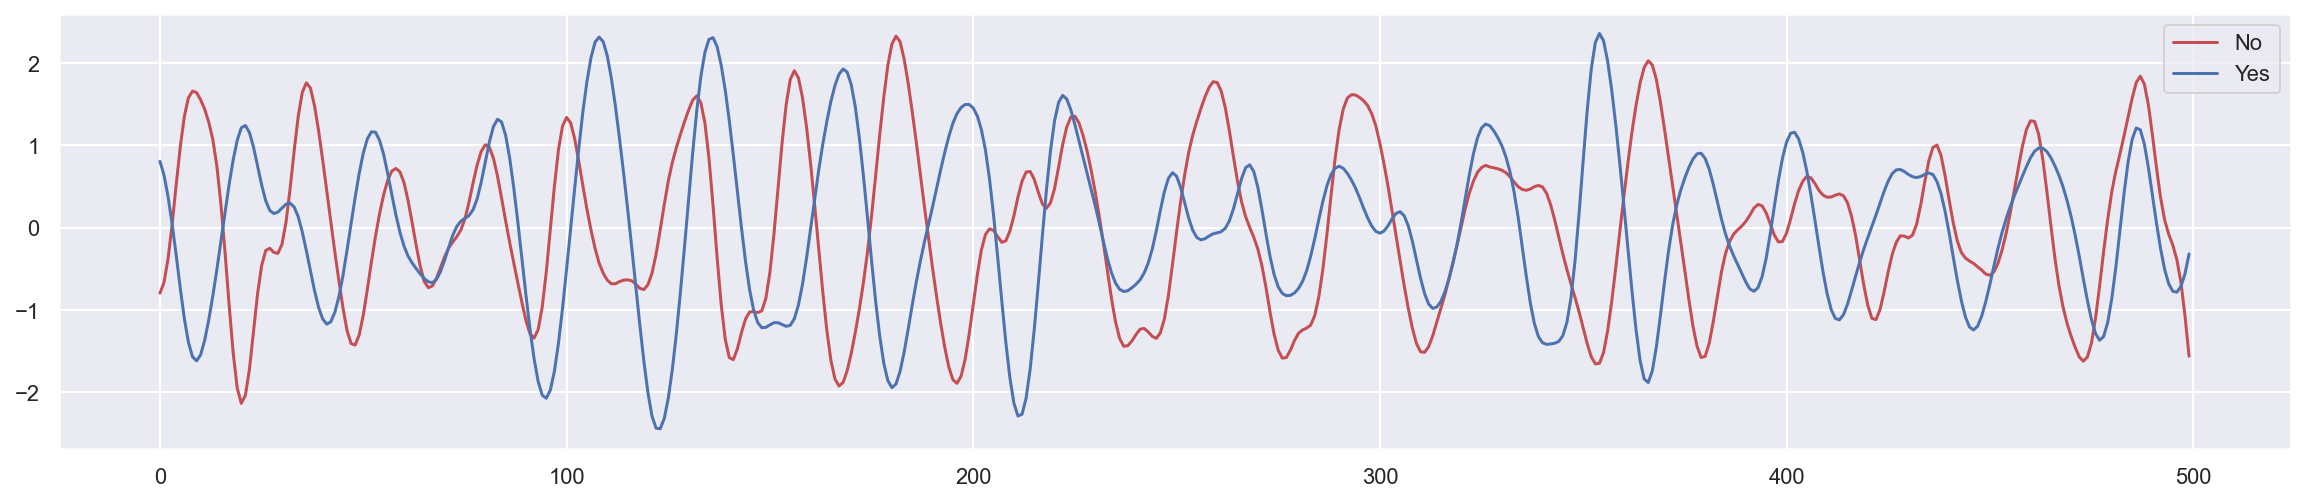

In [50]:
fig = plt.figure(figsize=(20,4))
plt.plot(X_train.iloc[0,:].values, color=colors[3], label='No');
plt.plot(X_train.iloc[1,:].values, color=colors[0], label='Yes');
plt.legend();

Entrena dos modelos genéricos.

In [51]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9000277700638711
0.5765151515151515


In [52]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9972229936128854
0.7265151515151516


### <font color="#00586D"> Creación de características </font>

<div class="alert alert-block alert-danger">

<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
En este ejemplo se crearán características de distinto tipo con fin de ver alternativas, pero **no son necesarias ni las más adecuadas** para este problema. 
</div>

Las características, por ejemplo, pueden obtenerse a partir la distribución de valores (independientemente del tiempo). 

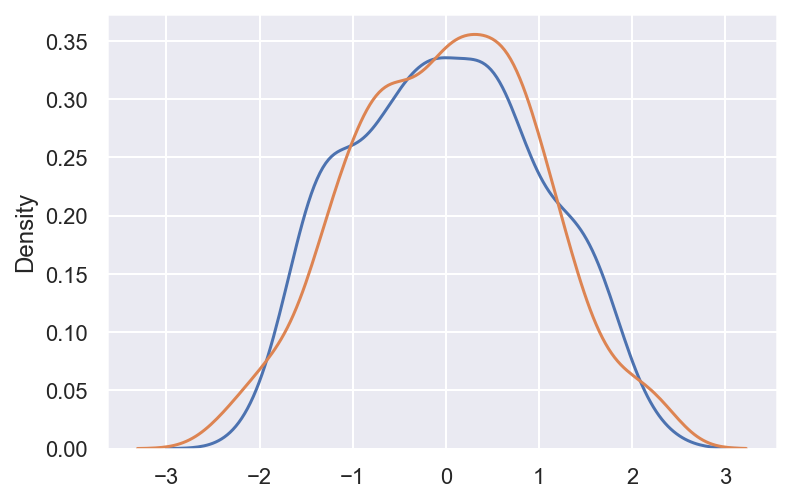

In [53]:
sns.kdeplot(X_train.iloc[0,:].values);
sns.kdeplot(X_train.iloc[1,:].values);

Podrían crearse características a partir del histograma. Por ejemplo, dados 20 bins, cada característica refleja la altura del bin correspondiente.

In [54]:
bins=np.linspace(-1,1,21)

X_train_hist = X_train.apply(lambda row: pd.Series(np.histogram(row, bins=bins)[0]), axis=1)
X_test_hist = X_test.apply(lambda row: pd.Series(np.histogram(row, bins=bins)[0]), axis=1)

X_train_hist

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0     13  10  12  19  14  17  15  15  20  21  15  13  16  18  20  18  17  15   
1     11  14  22  19  17  12  15  15  11  23  16  23  18  15  18  12  28  17   
2      7  12  21  17  17  25  17  14  23  21   9  23  19  20  23  23  15  15   
3     22  11  17  29  16  18  16  18  18  14  18  20  18  19  15  22  17  21   
4      7  13  13  15  17  21  19  24  19  24  15  27  21  21  24  23  17  25   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
3596   9  16  11  11  16  29  27  23  25  21  24  30  21  21  25  16  20  14   
3597   9  12  16  10  20  17  22  21  12  17  43  28  21  17  16  17  12  14   
3598  11  19  20  14  14  18  24  21  11  15  20  22  20  20  19  24  10  11   
3599  18  15  13  19  21  17  16  10  21  15  15  26  10   9  15  13  12  14   
3600  11  11  14  13  19  18  21  18  23  19  14  19  17  20  19  20  12  11   

      18  19  
0     11  10  
1     15  14  
2     18  10  
3     11  10  
4     18  16  
...   ..  ..  
3596   7  17  
3597  10   8  
3598  15  16  
3599  17  11  
3600   7  12  

[3601 rows x 20 columns]

En la gráfica se ve que hay ondas más acusadas que otras. Las diferencias entre un instante y el anterior contienen información a este respecto. También se puede utilizar esta distribución y/o hacer un histograma.

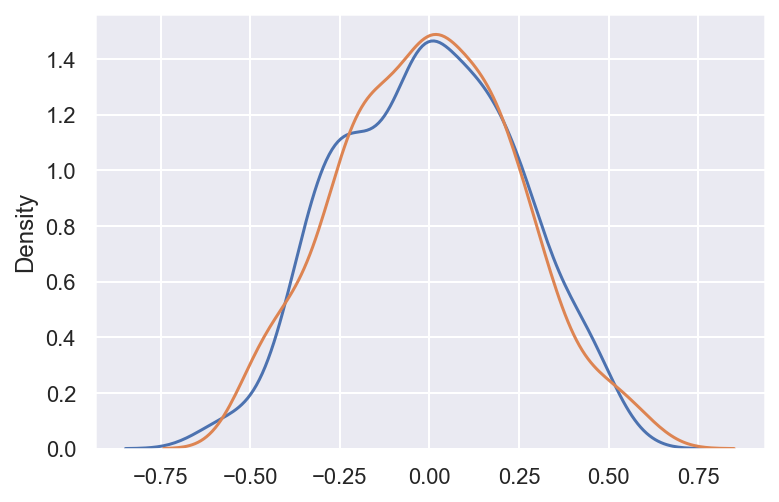

In [55]:
sns.kdeplot(X_train.iloc[0,:].diff().values);
sns.kdeplot(X_train.iloc[1,:].diff().values);

In [56]:
X_train_diff = X_train.apply(lambda row: pd.Series(np.histogram(row.diff(1), bins=bins)[0]), axis=1)
X_test_diff = X_test.apply(lambda row: pd.Series(np.histogram(row.diff(1), bins=bins)[0]), axis=1)

X_test_diff

0   1   2   3   4   5   6   7   8    9    10  11  12  13  14  15  16  \
0      4   4  12  21  22  21  35  43  36   36   56  44  43  39  19  30  13   
1      3   6   9  10  18  28  44  51  40   40   46  42  39  35  22  23  21   
2      0   5   2   3   6   6  11  23  76  123  111  73  21  15   6   3   2   
3      0   2   0   1  15  21  27  45  55   71   86  70  45  25  16  12   0   
4      0   0   3   6   5  25  30  38  67   71   75  57  55  28  27   9   3   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ..  ..  ..  ..  ..  ..   
1315   9  10  11  14  18  25  39  28  40   55   41  47  31  37  29  20  25   
1316   0   4   3   7  11  23  24  47  61   66   58  64  53  32  18   9  15   
1317   0   1   7  13  18  21  37  48  54   54   47  41  39  44  37  23   2   
1318   0   0   0   2   4   8  26  68  69   76   84  65  41  31  18   7   0   
1319   3   5   3   6  10  13  15  49  83   61   74  66  44  28  21   8   4   

      17  18  19  
0      7   5   2  
1      7   9   1  
2      4   1   3  
3      0   1   1  
4      0   0   0  
...   ..  ..  ..  
1315   6  10   2  
1316   4   0   0  
1317   6   4   0  
1318   0   0   0  
1319   2   0   2  

[1320 rows x 20 columns]

Otro tipo de características son resúmenes (media, varianza, etc) o algunas más complejas como, por ejemplo, la probabilidad de que los datos de una Serie, sin tener en cuenta el factor tiempo, procedan de una distribución normal. Esta información puede obtenerse mediante el test de Shapiro, que devuelve un estadístico y el p-valor. 


**Nota** Aquí no aporta mucho esta característica.


In [57]:
from scipy.stats import shapiro

X_train_norm = X_train.apply(lambda row: pd.Series(shapiro(row.diff().dropna())[0]), axis=1)
X_test_norm = X_test.apply(lambda row: pd.Series(shapiro(row.diff().dropna())[0]), axis=1)
X_train_norm

0
0     0.991180
1     0.993307
2     0.995528
3     0.994390
4     0.988487
...        ...
3596  0.975255
3597  0.994099
3598  0.994442
3599  0.987516
3600  0.989395

[3601 rows x 1 columns]

Otro tipo de características para series de tamaño fijo es el número de máximos/mínimos locales. Por ejemplo, la siguiente función muestra los máximos de la primera serie (algunos no se perciben claramente en la gráfica).

In [58]:
X_train.iloc[0,:].rolling(3, center=True).agg(lambda window: 1 if (window[0]<window[1]) and (window[2]<window[1]) else 0).sum()

27.0

In [59]:
X_train_max = X_train.apply(lambda row: row.rolling(3, center=True).agg(lambda window: 1 if (window[0]<window[1]) and (window[2]<window[1]) else 0).sum(), axis=1)
X_test_max = X_test.apply(lambda row: row.rolling(3, center=True).agg(lambda window: 1 if (window[0]<window[1]) and (window[2]<window[1]) else 0).sum(), axis=1)

X_test_max

0       39.0
1       43.0
2       21.0
3       28.0
4       26.0
        ... 
1315    39.0
1316    25.0
1317    32.0
1318    20.0
1319    25.0
Length: 1320, dtype: float64

En este ejemplo, se utilizan todas las características para entrenar dos clasificadores distintos.

In [60]:
X_train_feat = pd.concat((X_train_hist, X_train_diff, X_train_norm, X_train_max), axis=1)
X_test_feat = pd.concat((X_test_hist, X_test_diff, X_test_norm, X_test_max), axis=1)

X_train_feat

0   1   2   3   4   5   6   7   8   9   ...  12  13  14  15  16  17  18  \
0     13  10  12  19  14  17  15  15  20  21  ...  56  30  24   4   0   0   0   
1     11  14  22  19  17  12  15  15  11  23  ...  52  25  14  10   2   0   0   
2      7  12  21  17  17  25  17  14  23  21  ...  36  27  10  12   0   0   0   
3     22  11  17  29  16  18  16  18  18  14  ...  39  28  21   8  10   0   0   
4      7  13  13  15  17  21  19  24  19  24  ...  50  24  28  15   9   9   6   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
3596   9  16  11  11  16  29  27  23  25  21  ...  41  36   7   7   4   3   1   
3597   9  12  16  10  20  17  22  21  12  17  ...  34  35  14  11   6   4   2   
3598  11  19  20  14  14  18  24  21  11  15  ...  53  29  28  16  16   8   2   
3599  18  15  13  19  21  17  16  10  21  15  ...  41  35  18  17   2   0   0   
3600  11  11  14  13  19  18  21  18  23  19  ...  46  39  19  12   2   0   0   

      19        0     0   
0      0  0.991180  27.0  
1      0  0.993307  22.0  
2      0  0.995528  26.0  
3      0  0.994390  24.0  
4      5  0.988487  43.0  
...   ..       ...   ...  
3596   0  0.975255  25.0  
3597   0  0.994099  29.0  
3598   4  0.994442  38.0  
3599   0  0.987516  24.0  
3600   0  0.989395  22.0  

[3601 rows x 42 columns]

In [61]:
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train_feat, y_train)

print(clf.score(X_train_feat, y_train))
print(clf.score(X_test_feat, y_test))

0.8933629547347959
0.7371212121212121


In [62]:
clf = RandomForestClassifier(max_depth=15)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.740909090909091


### <font color="#00586D"> Clasificación de series temporales multivariantes </font>

En este ejemplo, cada serie temporal se caracteriza por los valores a lo largo del tiempo de un acelerómetro 3D y un giroscopio 3D. El objetivo es determinar, a partir de la información, la actividad de la persona que lo porta, que puede ser andar, descansar, correr o jugar al bádmington [(enlace)](https://timeseriesclassification.com/description.php?Dataset=BasicMotions).

In [63]:
from sktime.datasets import load_basic_motions

X, y = load_basic_motions(return_X_y=True)

Al convertir los datos a formato tabular, se crea una columna por cada dimensión/instante.

In [64]:
X_tab = from_nested_to_2d_array(X)
X_tab.rename(lambda label: label.replace('__',' t_'), axis='columns', inplace=True)

In [65]:
X_tab.head()

dim_0 t_0  dim_0 t_1  dim_0 t_2  dim_0 t_3  dim_0 t_4  dim_0 t_5  \
0   0.079106   0.079106  -0.903497   1.116125   1.638200   1.003448   
1   0.377751   0.377751   2.952965   4.310925   3.256906   0.850679   
2  -0.813905  -0.813905  -0.424628   0.316895   0.228580  -0.162312   
3   0.289855   0.289855  -0.669185   0.032063  -0.214649   0.161245   
4  -0.123238  -0.123238  -0.249547  -0.272929  -0.272929  -0.247999   

   dim_0 t_6  dim_0 t_7  dim_0 t_8  dim_0 t_9  ...  dim_5 t_90  dim_5 t_91  \
0   0.028774   0.030050  -0.120485  -0.120485  ...   -0.039951   -0.002663   
1  -0.909276  -0.909276   0.205036  -0.480176  ...    0.058594    0.143822   
2  -0.162312   0.002101   0.115463  -0.213192  ...    0.013317   -0.215733   
3   0.161245   0.374508   0.009226  -0.221630  ...    0.063921   -0.335585   
4  -0.247999   0.057938  -0.414336  -0.209641  ...    0.063921    0.122515   

   dim_5 t_92  dim_5 t_93  dim_5 t_94  dim_5 t_95  dim_5 t_96  dim_5 t_97  \
0    0.047941    0.071911    0.063921   -0.021307   -0.042614   -0.063921   
1    0.122515    0.039951   -0.039951   -0.039951   -0.135832   -0.135832   
2   -0.258347   -0.106535   -0.007990   -0.077238   -0.167792   -0.372872   
3   -0.218397   -0.143822   -0.143822    0.207743    0.436793    0.420813   
4    0.125179    0.125179    0.047941    0.047941   -0.117188   -0.141159   

   dim_5 t_98  dim_5 t_99  
0   -0.063921   -0.031960  
1    0.034624    0.034624  
2   -0.423476   -0.423476  
3    0.375536    0.074574  
4   -0.141159    0.000000  

[5 rows x 600 columns]

Entrena un modelo Random Forest

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tab, y, test_size=0.25)

In [67]:
clf = RandomForestClassifier(max_depth=10)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.85


### <font color="#00586D"> Extracción de características con tshfresh </font>

In [68]:
X_train, y_train = load_from_tsfile_to_dataframe('data/FordA_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe('data/FordA_TEST.ts')

`sktime` implementa un transformador que obtiene **todas** las características que calcula la librería `tsfresh`.

Esta operación requiere varios minutos.

In [69]:
transformer = TSFreshFeatureExtractor(show_warnings=False, disable_progressbar=True)

X_train_trans = transformer.fit_transform(X_train)
X_train_trans.shape

(3601, 777)

In [70]:
X_test_trans = transformer.transform(X_test)

In [71]:
clf = RandomForestClassifier(max_depth=10)
clf.fit(X_train_trans, y_train)

print(clf.score(X_train_trans, y_train))
print(clf.score(X_test_trans, y_test))

1.0
1.0


#### <font color="#00586D"> Clasificación con KNN + DTW</font>

<div class="alert alert-block alert-danger">

<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
El entrenamiento de este modelo requiere muchísimo tiempo.
</div>

In [72]:
#from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

#clf = KNeighborsTimeSeriesClassifier()
#clf.fit(X_train, y_train)

#print(clf.score(X_train, y_train))
#print(clf.score(X_test, y_test))

#### <font color="#00586D"> Clasificación con Time Series Forest Classifier</font>



In [73]:
from sktime.classification.interval_based import TimeSeriesForestClassifier

clf = TimeSeriesForestClassifier()
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.818939393939394


#### <font color="#00586D"> Clasificación con Supervised Time Series Forest</font>


In [74]:
from sktime.classification.interval_based import SupervisedTimeSeriesForest

clf = SupervisedTimeSeriesForest()
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.9674242424242424


#### <font color="#00586D"> Clasificación con BOSS</font>


El entrenamiento <div class="alert alert-block alert-danger">

<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
El entrenamiento de este modelo requiere muchísimo tiempo.
</div>

In [75]:
#from sktime.classification.dictionary_based import BOSSEnsemble

#clf = BOSSEnsemble()
#clf.fit(X_train, y_train)

#print(clf.score(X_train, y_train))
#print(clf.score(X_test, y_test))

#### <font color="#00586D"> Clasificación con ROCKET</font>



In [76]:
from sktime.transformations.panel.rocket import Rocket

rocket = Rocket()  
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

In [77]:
from sklearn.linear_model import RidgeClassifierCV
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [78]:
X_test_transform = rocket.transform(X_test)
classifier.score(X_test_transform, y_test)


0.9416666666666667

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section4"></a> 
## <font color="#00586D"> 4. Detección de anomalías en series temporales</font>
<br>



#### <font color="#00586D"> Ejemplo 1</font>

La serie contiene una tendencia y, por tanto, es difícil que haya valores que se salgan del rango. Sin embargo, sí que hay puntos en los que la variación con respecto al día anterior puede ser anómala. En este caso, calculamos las diferencias, su distribución, y catalogamos como valores anómalos los que estén a más de 3 desviaciones estándar de la media.

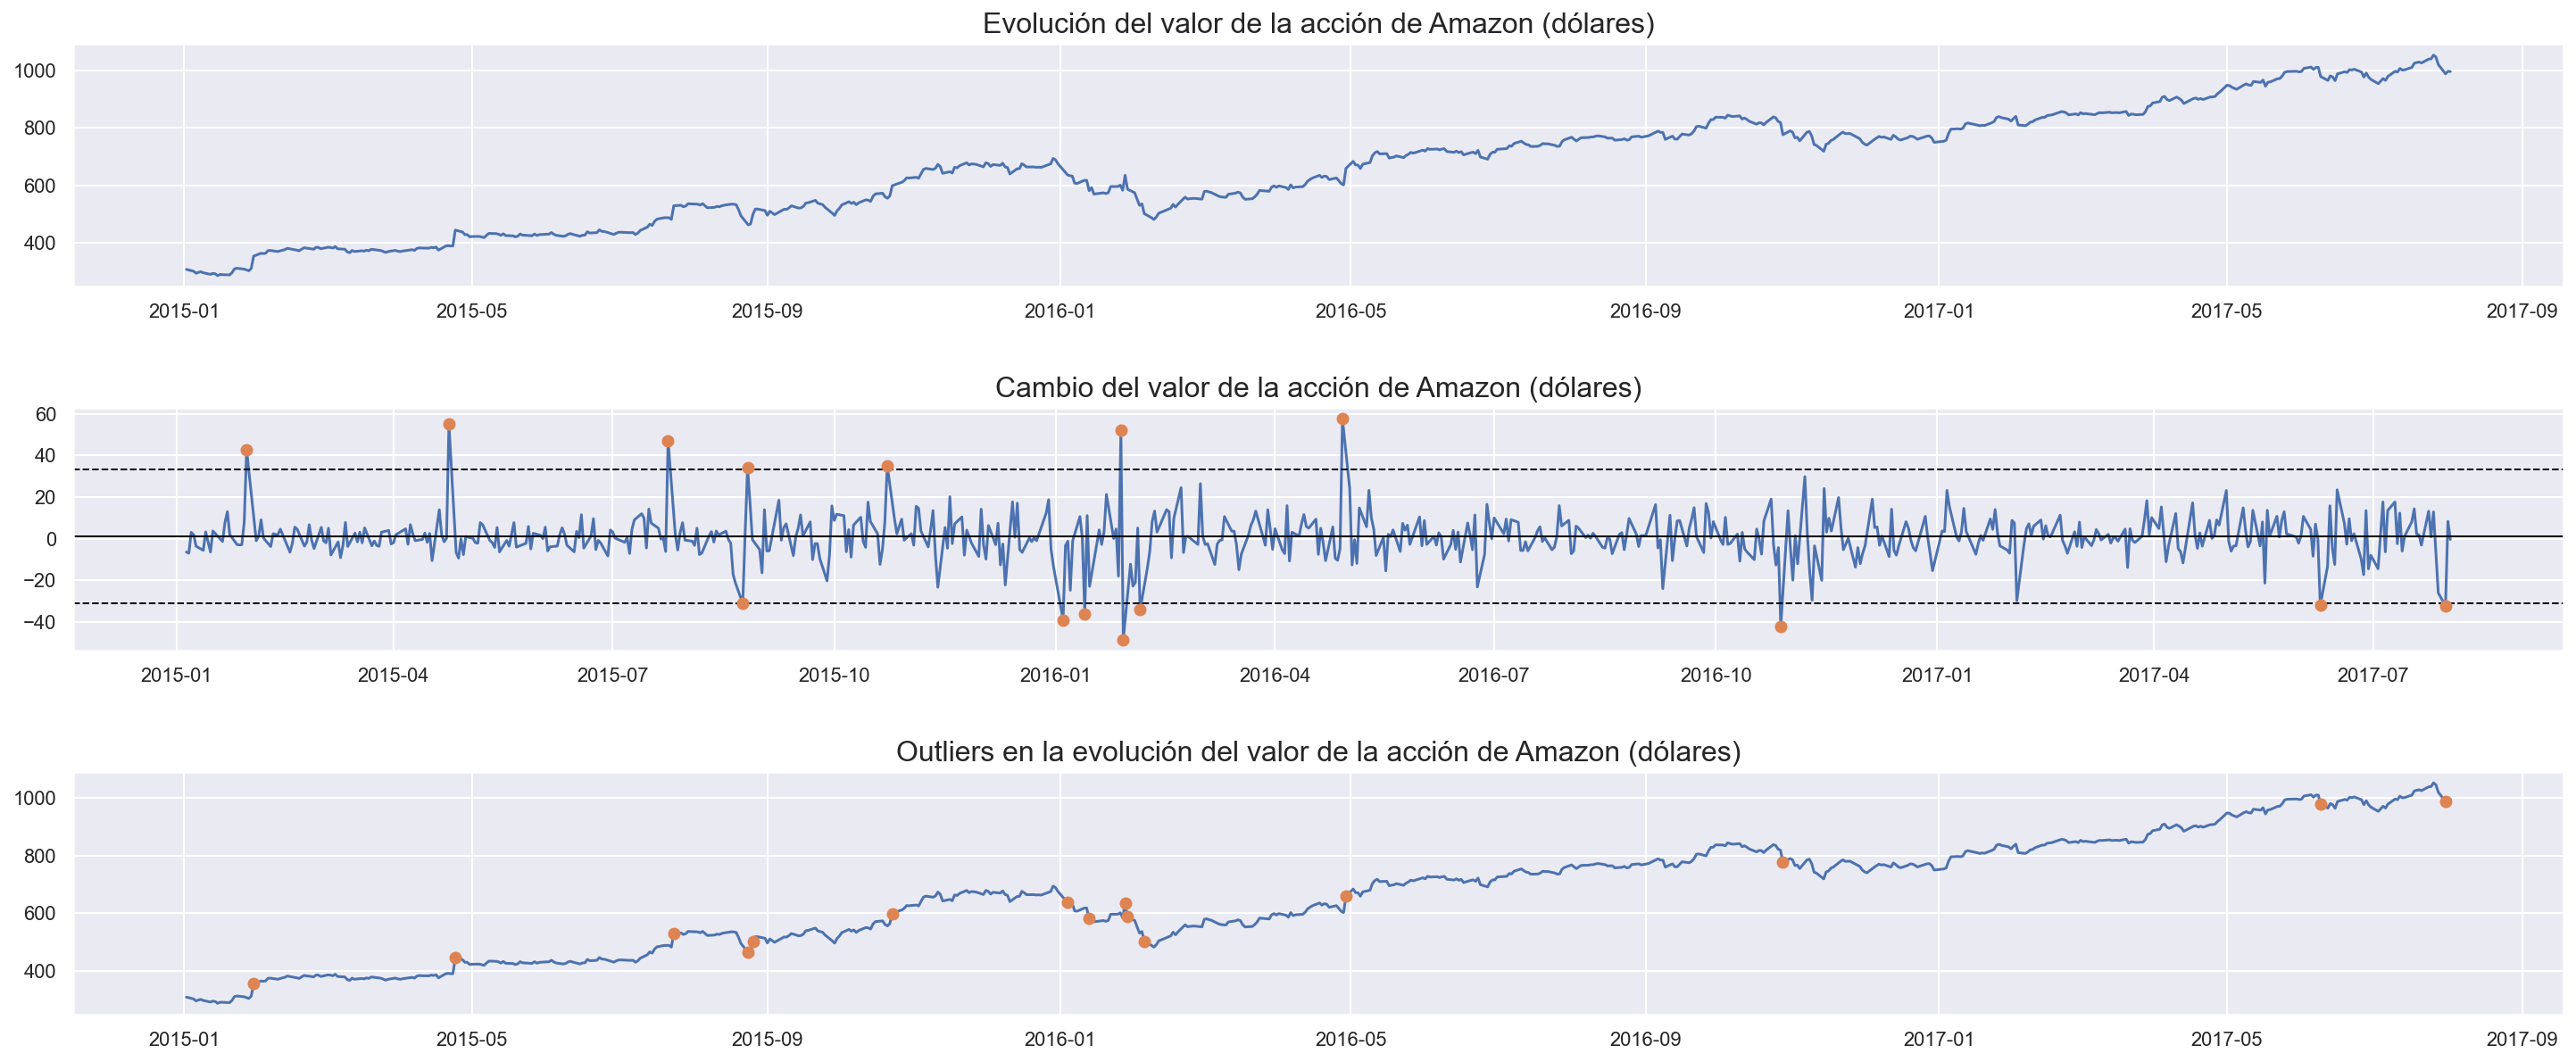

In [79]:
amzn = pd.read_csv('data/AMZN.csv', index_col=0)
amzn.index = pd.to_datetime(amzn.index)
amzn.columns=['Dólares']
amzn.index.name = 'Fecha'

fig, ax = plt.subplots(3,1,figsize=(25,10))

# Serie original
ax[0].plot(amzn['2015':].index, amzn['2015':]['Dólares']);
ax[0].set_title('Evolución del valor de la acción de Amazon (dólares)', fontsize=16);

# Serie con las diferencias
amzn_diff = amzn['2015':]['Dólares'].diff()
ax[1].plot(amzn_diff.index, amzn_diff);
ax[1].set_title('Cambio del valor de la acción de Amazon (dólares)', fontsize=16);
plt.subplots_adjust(hspace=0.5)

# Dibuja los outliers
mean = amzn_diff.mean()
std = amzn_diff.std()
outliers = amzn_diff[np.abs(amzn_diff-mean)>3*std]

# Serie con las diferencias
ax[1].axhline(mean+3*std, linestyle='--', color='black', linewidth=1)
ax[1].axhline(mean-3*std, linestyle='--', color='black', linewidth=1)
ax[1].axhline(mean, linestyle='-', color='black', linewidth=1)
ax[1].plot(outliers, linestyle='', marker='o')

# Serie original con outliers
ax[2].plot(amzn['2015':].index, amzn['2015':]['Dólares']);
ax[2].set_title('Outliers en la evolución del valor de la acción de Amazon (dólares)', fontsize=16);
ax[2].plot(outliers.index, amzn.loc[outliers.index,'Dólares'], linestyle='', marker='o');

#### <font color="#00586D"> Ejemplo 2</font>

Es parecido al anterior. En este caso se hace una descomposición y se procede con los residuos.

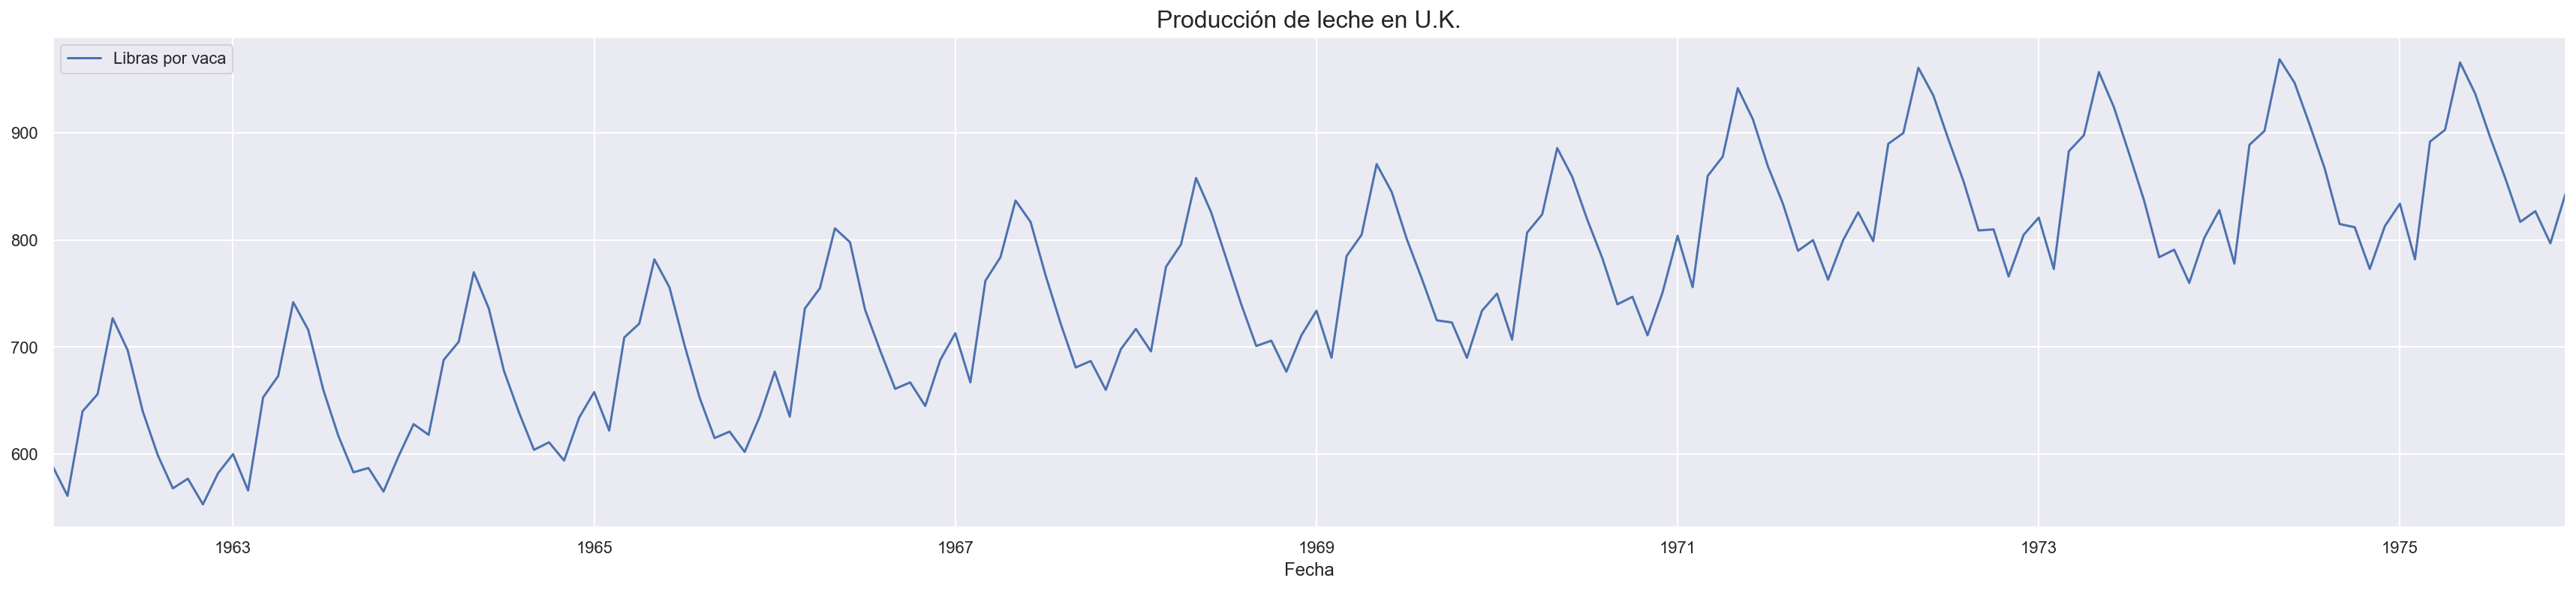

In [80]:
milk_production = pd.read_csv('data/milk_production.csv', index_col=0)
milk_production.index = pd.to_datetime(milk_production.index)
milk_production.columns=['Libras por vaca']
milk_production.index.name = 'Fecha'

fig, ax = plt.subplots(figsize=(30,6))
milk_production.plot(ax=ax, legend=True);
ax.set_title('Producción de leche en U.K.', fontsize=16);

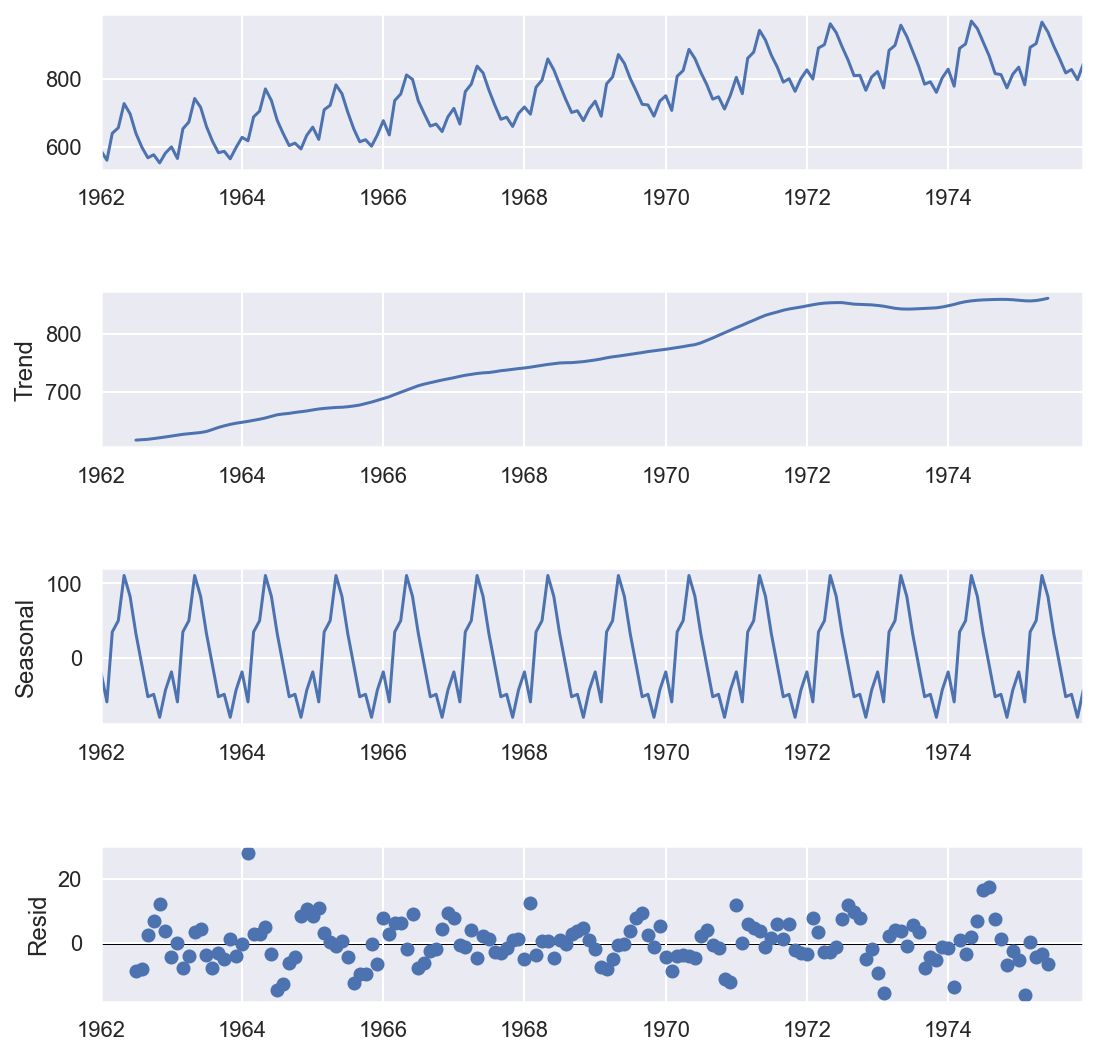

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(milk_production, period=12)
fig = decomp.plot();
fig.set_size_inches(8,8)

Calcula los valores anómalos a partir de los residuos.

In [82]:
mean = np.mean(decomp.resid)
std = np.std(decomp.resid)
outliers = decomp.resid[np.abs(decomp.resid-mean)>2*std]

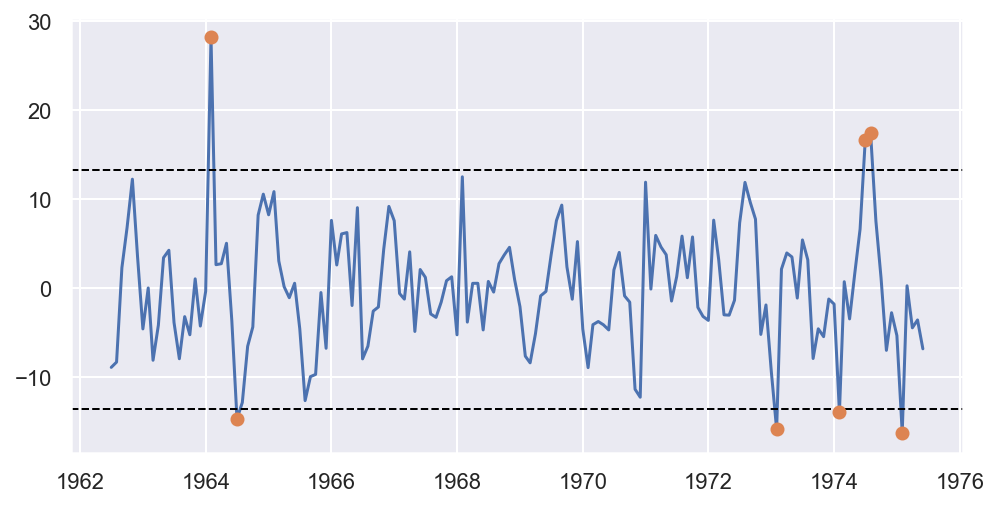

In [83]:
fig, ax = plt.subplots(figsize=(8,4), sharex=True)
ax.plot(decomp.resid)
ax.axhline(mean+2*std, linestyle='--', color='black', linewidth=1)
ax.axhline(mean-2*std, linestyle='--', color='black', linewidth=1)
ax.plot(outliers, linestyle='', marker='o')

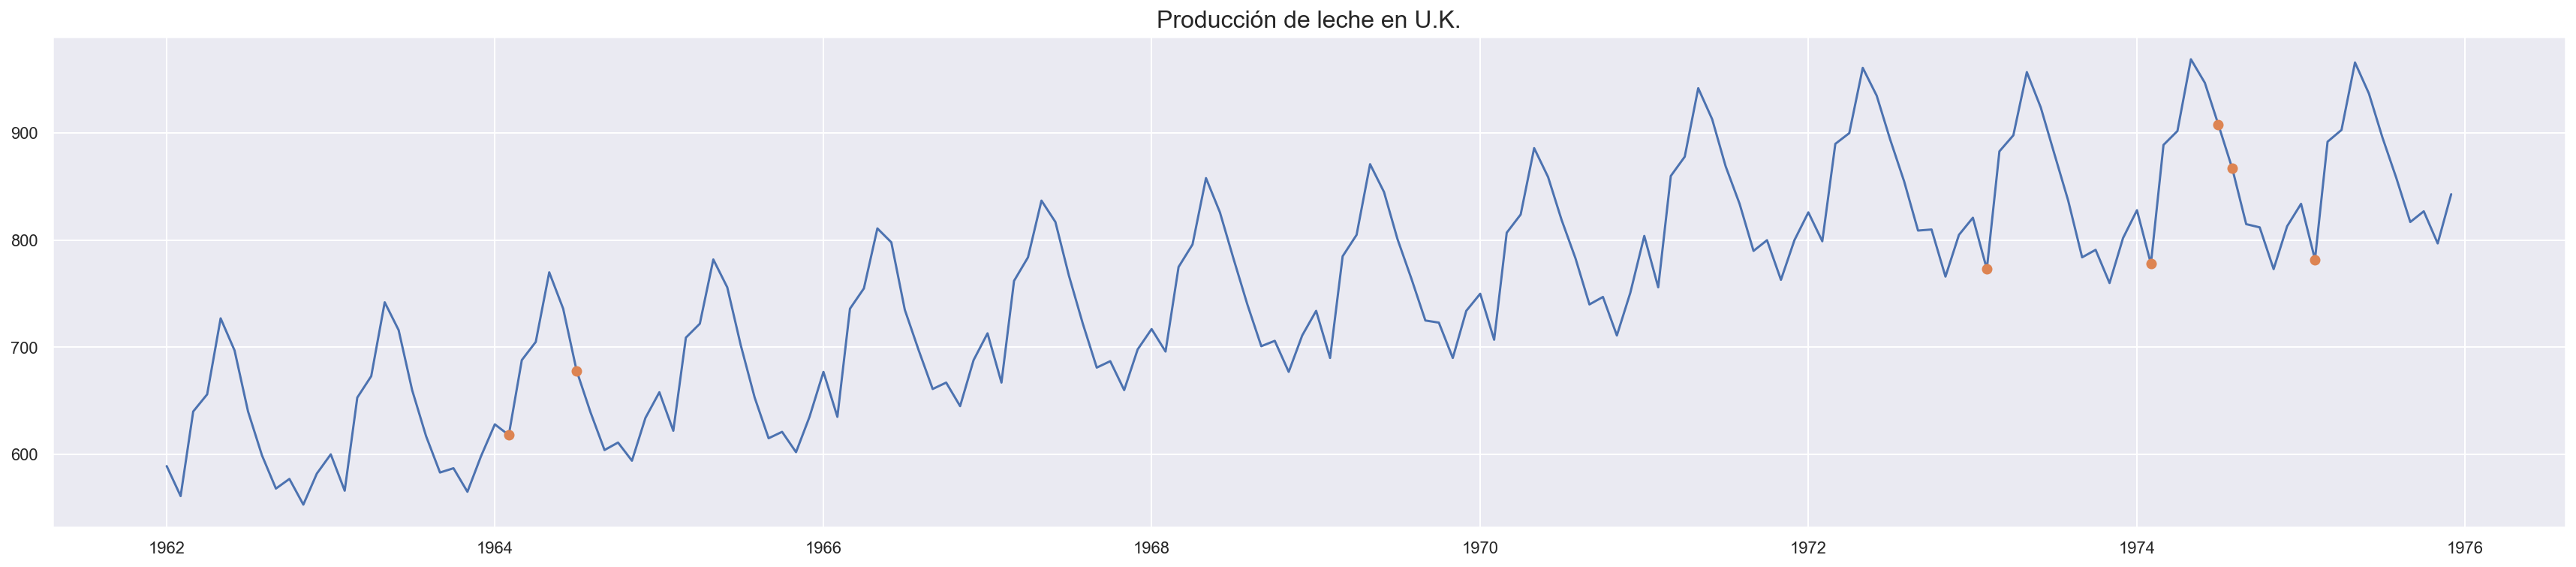

In [84]:
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(milk_production);
ax.set_title('Producción de leche en U.K.', fontsize=16);
ax.plot(milk_production.loc[outliers.index], linestyle='', marker='o');

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<div align="right">
<a href="#indice"><font size=6 color="#00586D"><i class="fa fa-coffee" aria-hidden="true"></i></font></a>
</div>